Number of bands in raster: 18


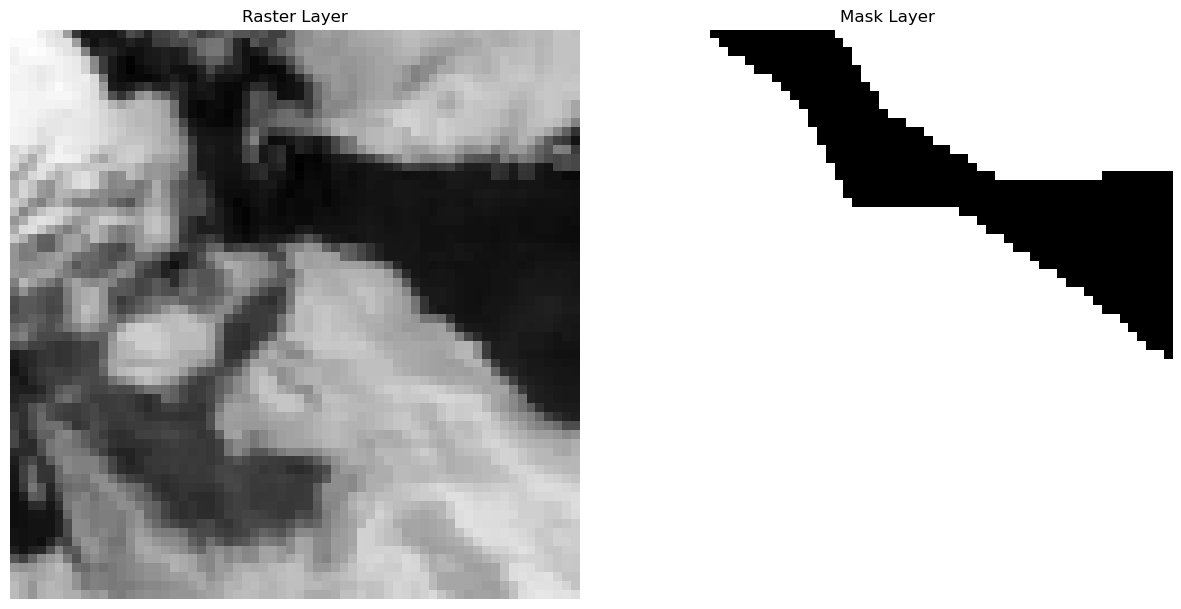

Number of bands in raster: 18


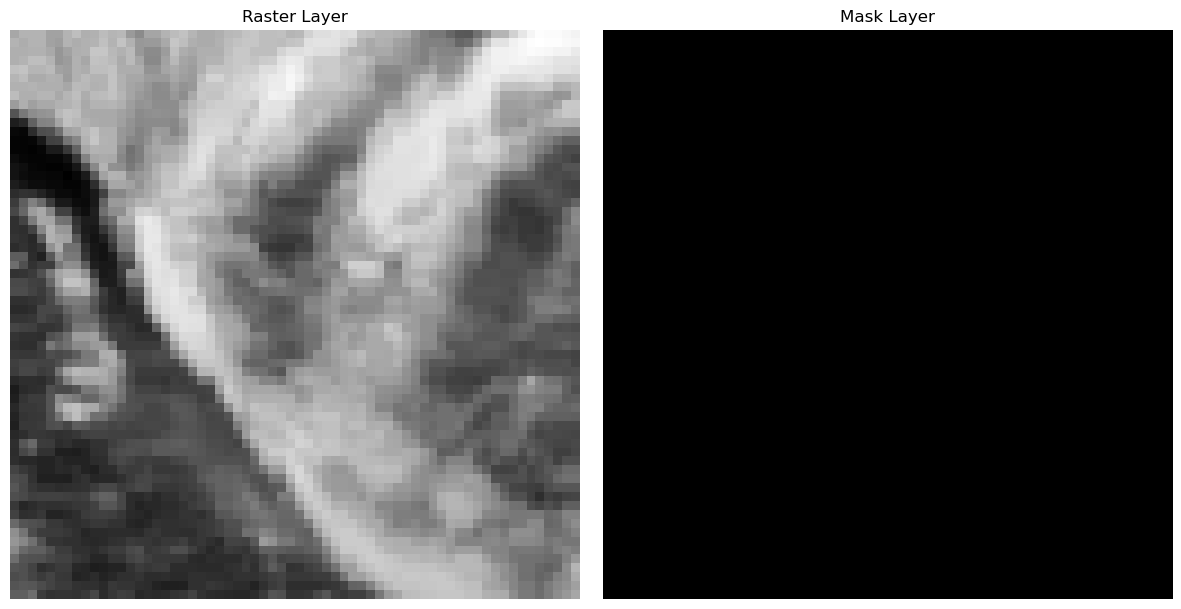

Number of bands in raster: 18


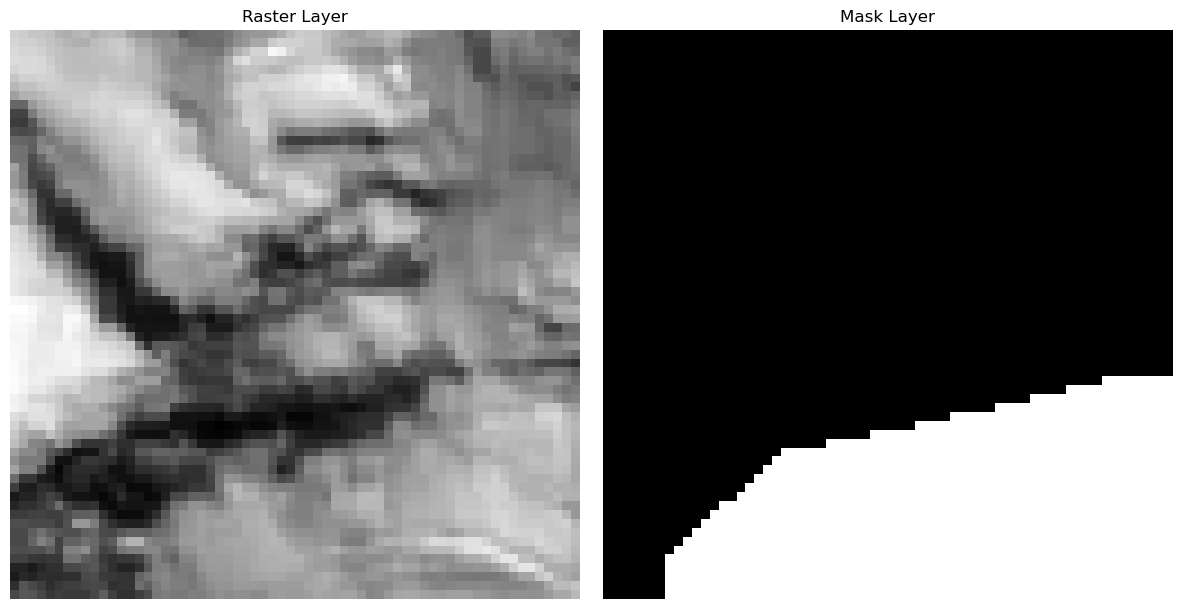

Number of bands in raster: 18


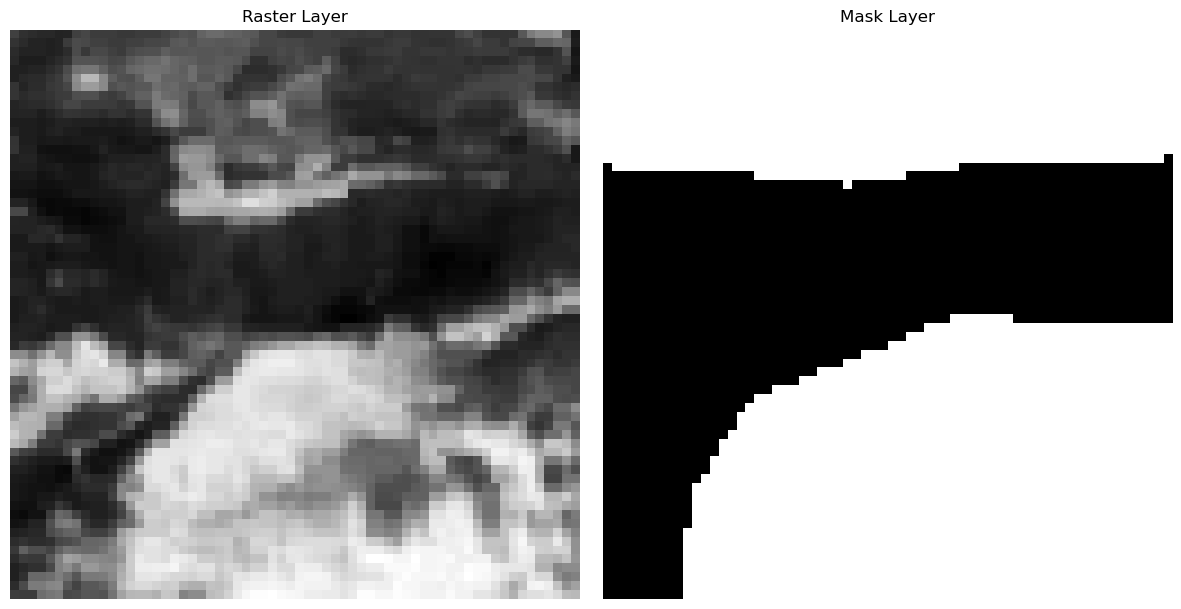

In [1]:
import os
import random
import rasterio
import matplotlib.pyplot as plt

# Output directories
output_raster_dir = "sarvesh/DATASETS_NORMALIZED/all_sau_net/gn2_all/rasterlayer"
output_mask_dir = "sarvesh/DATASETS_NORMALIZED/all_sau_net/gn2_all/masklayer"
patch_size = 64

# Get a list of patch files
raster_files = sorted([f for f in os.listdir(output_raster_dir) if f.endswith('.tif')])
mask_files = sorted([f for f in os.listdir(output_mask_dir) if f.endswith('.tif')])

# Randomly select 4 unique indices
if len(raster_files) >= 4 and len(mask_files) >= 4:
    random_indices = random.sample(range(len(raster_files)), 4)
else:
    print("Not enough raster or mask files available.")
    random_indices = []

# Visualization function for raster and mask
def visualize_layers(raster_file, mask_file):
    with rasterio.open(raster_file) as src_raster:
        # Check the number of bands in the raster
        num_bands = src_raster.count
        print(f"Number of bands in raster: {num_bands}")  # Debugging line

        # Select the first band (ensure it's the correct band)
        raster_data = src_raster.read(1)  # Change this if you want a different band

    with rasterio.open(mask_file) as src_mask:
        mask_data = src_mask.read(1)  # Read the first band (or layer)

    # Create a figure with subplots
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Plot raster
    ax[0].imshow(raster_data, cmap='gray')
    ax[0].set_title('Raster Layer')
    ax[0].axis('off')  # Hide axis

    # Plot mask
    ax[1].imshow(mask_data, cmap='gray')
    ax[1].set_title('Mask Layer')
    ax[1].axis('off')  # Hide axis

    plt.tight_layout()
    plt.show()

# Visualize the selected random patches
for index in random_indices:
    visualize_layers(os.path.join(output_raster_dir, raster_files[index]),
                     os.path.join(output_mask_dir, mask_files[index]))

In [1]:
import os
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler
from osgeo import gdal
import random
import tensorflow as tf
from matplotlib import pyplot as plt
from concurrent.futures import ProcessPoolExecutor
import rasterio
from rasterio.windows import Window

2025-05-03 22:53:15.657724: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-03 22:53:15.657811: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-03 22:53:15.657859: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-03 22:53:15.667490: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-03 22:53:16.695946: W tensorflow/compiler/

In [2]:
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [4]:
import os
import rasterio
import numpy as np

output_raster_dir = "sarvesh/DATASETS_NORMALIZED/all_sau_net/gn2_all/rasterlayer"
output_mask_dir = "sarvesh/DATASETS_NORMALIZED/all_sau_net/gn2_all/masklayer"

# Function to check if a file is a valid raster
def is_valid_raster(file_path):
    try:
        with rasterio.open(file_path) as src:
            return True
    except:
        return False

# Function to load patches and calculate metrics
def load_and_calculate_metrics(raster_dir, mask_dir):
    raster_files = sorted([f for f in os.listdir(raster_dir) if is_valid_raster(os.path.join(raster_dir, f))])
    mask_files = sorted([f for f in os.listdir(mask_dir) if is_valid_raster(os.path.join(mask_dir, f))])

    if not raster_files or not mask_files:
        print("No valid raster or mask files found.")
        return

    # Load first raster file to extract dimensions
    with rasterio.open(os.path.join(raster_dir, raster_files[0])) as src:
        raster_height = src.height
        raster_width = src.width
        raster_channels = src.count

    # Count the number of patches
    raster_length = len(raster_files)
    mask_length = len(mask_files)

    # Check for the total classes in the mask
    mask_classes = set()

    for mask_file in mask_files:
        with rasterio.open(os.path.join(mask_dir, mask_file)) as mask_src:
            mask_data = mask_src.read(1)  # Read the first band
            mask_classes.update(np.unique(mask_data))

    # Print the calculated metrics
    print("Length of raster dataset:", raster_length)
    print("Length of mask dataset:", mask_length)
    print("Raster height:", raster_height)
    print("Raster width:", raster_width)
    print("Raster channels:", raster_channels)
    print("Total classes of mask (1 for glacier, 0 for non-glacier):", sorted(mask_classes))

# Call the function to load datasets and calculate metrics
load_and_calculate_metrics(output_raster_dir, output_mask_dir)

Length of raster dataset: 38088
Length of mask dataset: 38088
Raster height: 64
Raster width: 64
Raster channels: 18
Total classes of mask (1 for glacier, 0 for non-glacier): [0, 1]


In [5]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [6]:
import os
import numpy as np
import rasterio
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# Define paths
output_raster_dir = "sarvesh/DATASETS_NORMALIZED/all_sau_net/gn2_all/rasterlayer"
output_mask_dir = "sarvesh/DATASETS_NORMALIZED/all_sau_net/gn2_all/masklayer"

# Function to load raster dataset
def load_raster_dataset(directory):
    image_list = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.tif'):
            file_path = os.path.join(directory, filename)
            with rasterio.open(file_path) as src:
                image_data = src.read()  # (channels, height, width)
                image_list.append(image_data)
    return np.stack(image_list, axis=0) if image_list else np.array([])

# Function to load mask dataset
def load_mask_dataset(directory):
    mask_list = []
    mask_files = sorted([f for f in os.listdir(directory) if f.endswith('.tif')])
    for filename in mask_files:
        file_path = os.path.join(directory, filename)
        with rasterio.open(file_path) as src:
            mask_data = src.read(1)  # (height, width) single band
            mask_list.append(mask_data)
    return np.array(mask_list)

# Load raster data
image_dataset = load_raster_dataset(output_raster_dir)
print("Original image dataset shape:", image_dataset.shape)

# Transpose image data to (n_samples, height, width, channels)
if image_dataset.ndim == 4:
    image_dataset = np.transpose(image_dataset, (0, 2, 3, 1))  # from (N, C, H, W) to (N, H, W, C)
    print("Transposed image dataset shape:", image_dataset.shape)
else:
    print("Warning: Unexpected image dataset shape.")

# Extract dimensions
if image_dataset.size > 0:
    image_height, image_width, image_channels = image_dataset.shape[1:]
    print("Image height:", image_height)
    print("Image width:", image_width)
    print("Image channels:", image_channels)
else:
    print("Error: Empty image dataset!")

# Load mask data
mask_dataset = load_mask_dataset(output_mask_dir)
print("Mask dataset shape:", mask_dataset.shape)
print("Length of mask dataset:", len(mask_dataset))

# Unique classes in the masks
unique_labels = np.unique(mask_dataset)
total_classes = len(unique_labels)
print("Unique labels in masks:", unique_labels)
print("Total number of unique classes:", total_classes)

# One-hot encode the masks
labels_categorical_dataset = to_categorical(mask_dataset, num_classes=total_classes)

# Train-test split
if image_dataset.shape[0] == labels_categorical_dataset.shape[0]:
    X_train, X_test, y_train, y_test = train_test_split(
        image_dataset,
        labels_categorical_dataset,
        test_size=0.2,
        random_state=100
    )

    print("Dataset split completed.")
    print("Training set shape (X, y):", X_train.shape, y_train.shape)
    print("Testing set shape (X, y):", X_test.shape, y_test.shape)
else:
    print("Mismatch in number of images and masks!")

Original image dataset shape: (38088, 18, 64, 64)
Transposed image dataset shape: (38088, 64, 64, 18)
Image height: 64
Image width: 64
Image channels: 18
Mask dataset shape: (38088, 64, 64)
Length of mask dataset: 38088
Unique labels in masks: [0. 1.]
Total number of unique classes: 2
Dataset split completed.
Training set shape (X, y): (30470, 64, 64, 18) (30470, 64, 64, 2)
Testing set shape (X, y): (7618, 64, 64, 18) (7618, 64, 64, 2)


In [7]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(30470, 64, 64, 18)
(7618, 64, 64, 18)
(30470, 64, 64, 2)
(7618, 64, 64, 2)


In [8]:
from keras.optimizers import Adam
from tensorflow.keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda
from keras import backend as K

In [9]:
import os
import numpy as np
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

In [10]:
import tensorflow as tf
from tensorflow.keras import backend as K 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Dropout, Add, Activation, Multiply, GlobalAveragePooling2D, DepthwiseConv2D, Reshape, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import cv2

In [11]:
output_raster_dir = "sarvesh/DATASETS_NORMALIZED/all_sau_net/gn2_all/rasterlayer"
output_mask_dir = "sarvesh/DATASETS_NORMALIZED/all_sau_net/gn2_all/masklayer"
patch_size = 64  # Ensure your patches match your input shape

# Function to load raster dataset
def load_raster_dataset(directory):
    image_list = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.tif'):
            file_path = os.path.join(directory, filename)
            with rasterio.open(file_path) as src:
                image_data = src.read()
                image_list.append(image_data)
    return np.stack(image_list, axis=0) if image_list else np.array([])

In [12]:
# Function to load mask dataset
def load_mask_dataset(directory):
    mask_list = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.tif'):
            file_path = os.path.join(directory, filename)
            with rasterio.open(file_path) as src:
                mask_data = src.read(1)
                mask_list.append(mask_data)
    return np.stack(mask_list, axis=0) if mask_list else np.array([])

# Load datasets
image_dataset = load_raster_dataset(output_raster_dir)
mask_dataset = load_mask_dataset(output_mask_dir)

# Transpose image dataset to have channels last
image_dataset = np.transpose(image_dataset, (0, 2, 3, 1))

# Normalize image data
#image_dataset = image_dataset.astype('float32') / 255.0

# Convert mask to categorical
unique_labels = np.unique(mask_dataset)
total_classes = len(unique_labels)
mask_dataset_cat = to_categorical(mask_dataset, num_classes=total_classes)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    image_dataset, mask_dataset_cat, test_size=0.2, random_state=100
)

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, 
    UpSampling2D, Concatenate, Add, Dense, MultiHeadAttention, LayerNormalization
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision
import segmentation_models as sm 

In [14]:
# === 2. Jaccard Coefficient Metric ===
def jaccard_coef(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    y_true_flatten = tf.reshape(y_true, [-1])
    y_pred_flatten = tf.reshape(y_pred, [-1])
    
    intersection = tf.reduce_sum(y_true_flatten * y_pred_flatten)
    final_coef_value = (intersection + 1.0) / (tf.reduce_sum(y_true_flatten) + tf.reduce_sum(y_pred_flatten) - intersection + 1.0)
    
    return final_coef_value

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# === Building Blocks ===
def res_block(x, filters, kernel_size=3):
    shortcut = Conv2D(filters, 1, padding='same')(x)
    shortcut = BatchNormalization()(shortcut)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def vision_transformer_block(x, patch_size, embed_dim, num_heads, num_blocks):
    input_shape = x.shape[1:3]  # (height, width)
    patch_h, patch_w = patch_size, patch_size

    num_patches_h = input_shape[0] // patch_h
    num_patches_w = input_shape[1] // patch_w
    num_patches = num_patches_h * num_patches_w
    patch_dim = x.shape[-1] * patch_h * patch_w

    batch_size = tf.shape(x)[0]
    
    patches = tf.image.extract_patches(
        images=x,
        sizes=[1, patch_h, patch_w, 1],
        strides=[1, patch_h, patch_w, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )

    patches = tf.reshape(patches, [batch_size, num_patches, patch_dim])

    embedded = Dense(embed_dim)(patches)

    position_embedding = Embedding(input_dim=num_patches, output_dim=embed_dim)
    positions = tf.range(start=0, limit=num_patches, delta=1)
    embedded += position_embedding(positions)

    for _ in range(num_blocks):
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(embedded, embedded)
        attn_output = Dropout(0.1)(attn_output)
        embedded = LayerNormalization(epsilon=1e-6)(embedded + attn_output)

        ffn_output = Dense(embed_dim * 4, activation='relu')(embedded)
        ffn_output = Dense(embed_dim)(ffn_output)
        ffn_output = Dropout(0.1)(ffn_output)
        embedded = LayerNormalization(epsilon=1e-6)(embedded + ffn_output)

    # Reshape back to feature map
    grid_size_h = num_patches_h
    grid_size_w = num_patches_w
    x = tf.reshape(embedded, [batch_size, grid_size_h, grid_size_w, embed_dim])

    # Resize to original input shape
    x = tf.image.resize(x, [input_shape[0], input_shape[1]])
    return x

def attention_gate(x, skip, filters):
    g1 = Conv2D(filters, 1, padding='same')(x)
    g1 = BatchNormalization()(g1)

    x1 = Conv2D(filters, 1, padding='same')(skip)
    x1 = BatchNormalization()(x1)

    attention = Activation('relu')(g1 + x1)
    attention = Conv2D(1, 1, activation='sigmoid')(attention)

    skip = tf.multiply(skip, attention)
    return skip

# === GlaViTU Model ===
def build_glavitu(input_shape=(64, 64, 18), n_classes=2):
    inputs = Input(shape=input_shape)

    # Initial Convolution
    x = Conv2D(64, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Vision Transformer Block
    vt = vision_transformer_block(x, patch_size=4, embed_dim=64, num_heads=4, num_blocks=4)

    # Fusion
    fused = Concatenate()([x, vt])
    fused = Conv2D(128, 1, padding='same')(fused)
    fused = BatchNormalization()(fused)
    fused = Activation('relu')(fused)

    # Encoder
    e1 = res_block(fused, 128)
    p1 = MaxPooling2D(pool_size=(2, 2))(e1)

    e2 = res_block(p1, 256)
    p2 = MaxPooling2D(pool_size=(2, 2))(e2)

    e3 = res_block(p2, 512)

    # Decoder
    u1 = UpSampling2D(size=(2, 2))(e3)
    a1 = attention_gate(u1, e2, 256)
    u1 = Concatenate()([u1, a1])
    u1 = res_block(u1, 256)

    u2 = UpSampling2D(size=(2, 2))(u1)
    a2 = attention_gate(u2, e1, 128)
    u2 = Concatenate()([u2, a2])
    u2 = res_block(u2, 128)

    # Output
    outputs = Conv2D(n_classes, 1, activation='softmax')(u2)

    model = Model(inputs, outputs)
    return model


In [16]:
# === 6. Compile the Model ===
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
total_classes = y_train.shape[-1]  # Assuming y_train is one-hot encoded

model = build_glavitu(input_shape=input_shape, n_classes=total_classes)

dice_loss = sm.losses.DiceLoss(class_weights=[0.3, 0.7])
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

model = build_glavitu(input_shape=(64, 64, 18), n_classes=2)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

2025-04-26 18:06:12.971389: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13671 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:a1:00.0, compute capability: 8.6


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 18)]         0         []                            
                                                                                                  
 conv2d_24 (Conv2D)          (None, 64, 64, 64)           10432     ['input_2[0][0]']             
                                                                                                  
 batch_normalization_21 (Ba  (None, 64, 64, 64)           256       ['conv2d_24[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_14 (Activation)  (None, 64, 64, 64)           0         ['batch_normalization_21

In [17]:
# === 7. Callbacks ===
model_save_path = 'sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/sf/model/glavitu_all_area.h5'

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

model_checkpoint = ModelCheckpoint(
    model_save_path,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

In [18]:
# === 8. Training ===
batch_size = 16

history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=1000,
    validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/1000


2025-04-26 18:06:35.377498: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-04-26 18:06:39.722326: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x70f6a53ad790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-26 18:06:39.722379: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2025-04-26 18:06:39.728355: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-26 18:06:39.871575: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1905/1905 [==============================] - ETA: 0s - loss: 0.2894 - accuracy: 0.8774
Epoch 1: val_loss improved from inf to 0.25942, saving model to sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/sf/model/glavitu_all_area.h5


/home/sarvesh/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1905/1905 [==============================] - 263s 120ms/step - loss: 0.2894 - accuracy: 0.8774 - val_loss: 0.2594 - val_accuracy: 0.8870
Epoch 2/1000
1905/1905 [==============================] - ETA: 0s - loss: 0.2568 - accuracy: 0.8909
Epoch 2: val_loss improved from 0.25942 to 0.24647, saving model to sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/sf/model/glavitu_all_area.h5
1905/1905 [==============================] - 242s 127ms/step - loss: 0.2568 - accuracy: 0.8909 - val_loss: 0.2465 - val_accuracy: 0.8938
Epoch 3/1000
1905/1905 [==============================] - ETA: 0s - loss: 0.2448 - accuracy: 0.8954
Epoch 3: val_loss improved from 0.24647 to 0.24097, saving model to sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/sf/model/glavitu_all_area.h5
1905/1905 [==============================] - 247s 130ms/step - loss: 0.2448 - accuracy: 0.8954 - val_loss: 0.2410 - val_accuracy: 0.8981
Epoch 4/1000
1905/1905 [==============================] - ETA: 0s - loss: 0.2354 - accuracy: 0.8996

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1905/1905 [==============================] - ETA: 0s - loss: 0.0570 - accuracy: 0.9762
Epoch 55: val_loss improved from 0.06620 to 0.06508, saving model to sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/sf/model/glavitu_all_area.h5
1905/1905 [==============================] - 246s 129ms/step - loss: 0.0570 - accuracy: 0.9762 - val_loss: 0.0651 - val_accuracy: 0.9730
Epoch 56/1000
1441/1905 [=====================>........] - ETA: 55s - loss: 0.0554 - accuracy: 0.9769

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1905/1905 [==============================] - ETA: 0s - loss: 0.0367 - accuracy: 0.9846
Epoch 89: val_loss improved from 0.05232 to 0.05180, saving model to sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/sf/model/glavitu_all_area.h5
1905/1905 [==============================] - 242s 127ms/step - loss: 0.0367 - accuracy: 0.9846 - val_loss: 0.0518 - val_accuracy: 0.9789
Epoch 90/1000
1905/1905 [==============================] - ETA: 0s - loss: 0.0388 - accuracy: 0.9839
Epoch 90: val_loss improved from 0.05180 to 0.05080, saving model to sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/sf/model/glavitu_all_area.h5
1905/1905 [==============================] - 244s 128ms/step - loss: 0.0388 - accuracy: 0.9839 - val_loss: 0.0508 - val_accuracy: 0.9795
Epoch 91/1000
1905/1905 [==============================] - ETA: 0s - loss: 0.0358 - accuracy: 0.9851
Epoch 91: val_loss did not improve from 0.05080
1905/1905 [==============================] - 244s 128ms/step - loss: 0.0358 - accuracy: 0.9851 - 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [19]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Model output shape:", model.output.shape)

X_train shape: (30470, 64, 64, 18)
y_train shape: (30470, 64, 64, 2)
Model output shape: (None, 64, 64, 2)


In [20]:
# Check model output shape at different stages
print("Model output shape:", model.output.shape)

# Check the shape of y_train
print("Training labels shape:", y_train.shape)

Model output shape: (None, 64, 64, 2)
Training labels shape: (30470, 64, 64, 2)


Text(0.5, 1.0, 'Model Accuracy')

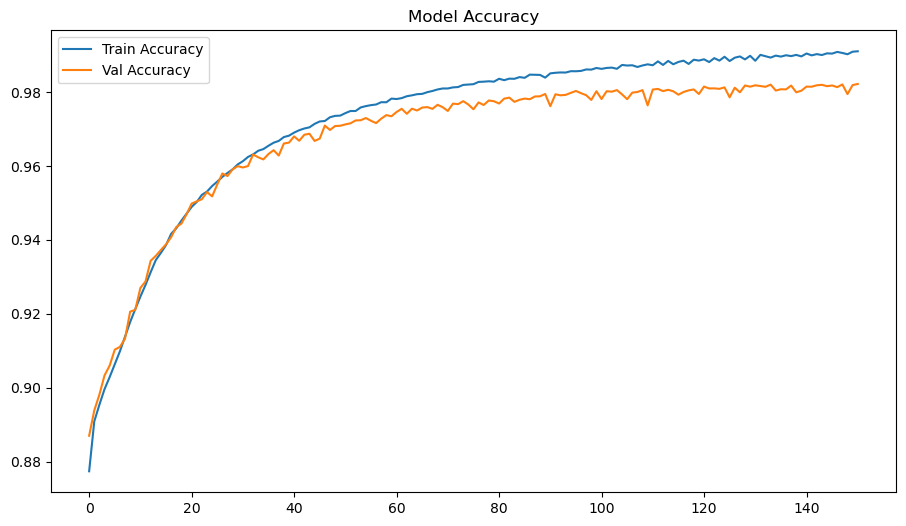

In [21]:
# Plot training results
plt.figure(figsize=(24, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Model Accuracy')

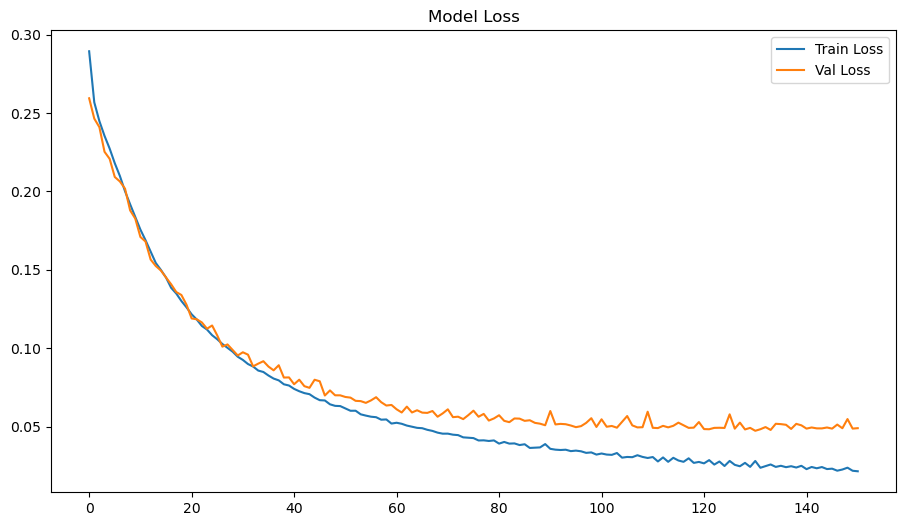

In [22]:
plt.figure(figsize=(24, 6))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [23]:
#Predict on the test set
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)

239/239 [==============================] - 18s 66ms/step


In [24]:
# Convert y_test to argmax for comparison
y_test_argmax = np.argmax(y_test, axis=3)

In [25]:
# Select a random test image for prediction visualization
test_image_number = random.randint(0, len(X_test) - 1)

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

1/1 [==============================] - 0s 48ms/step


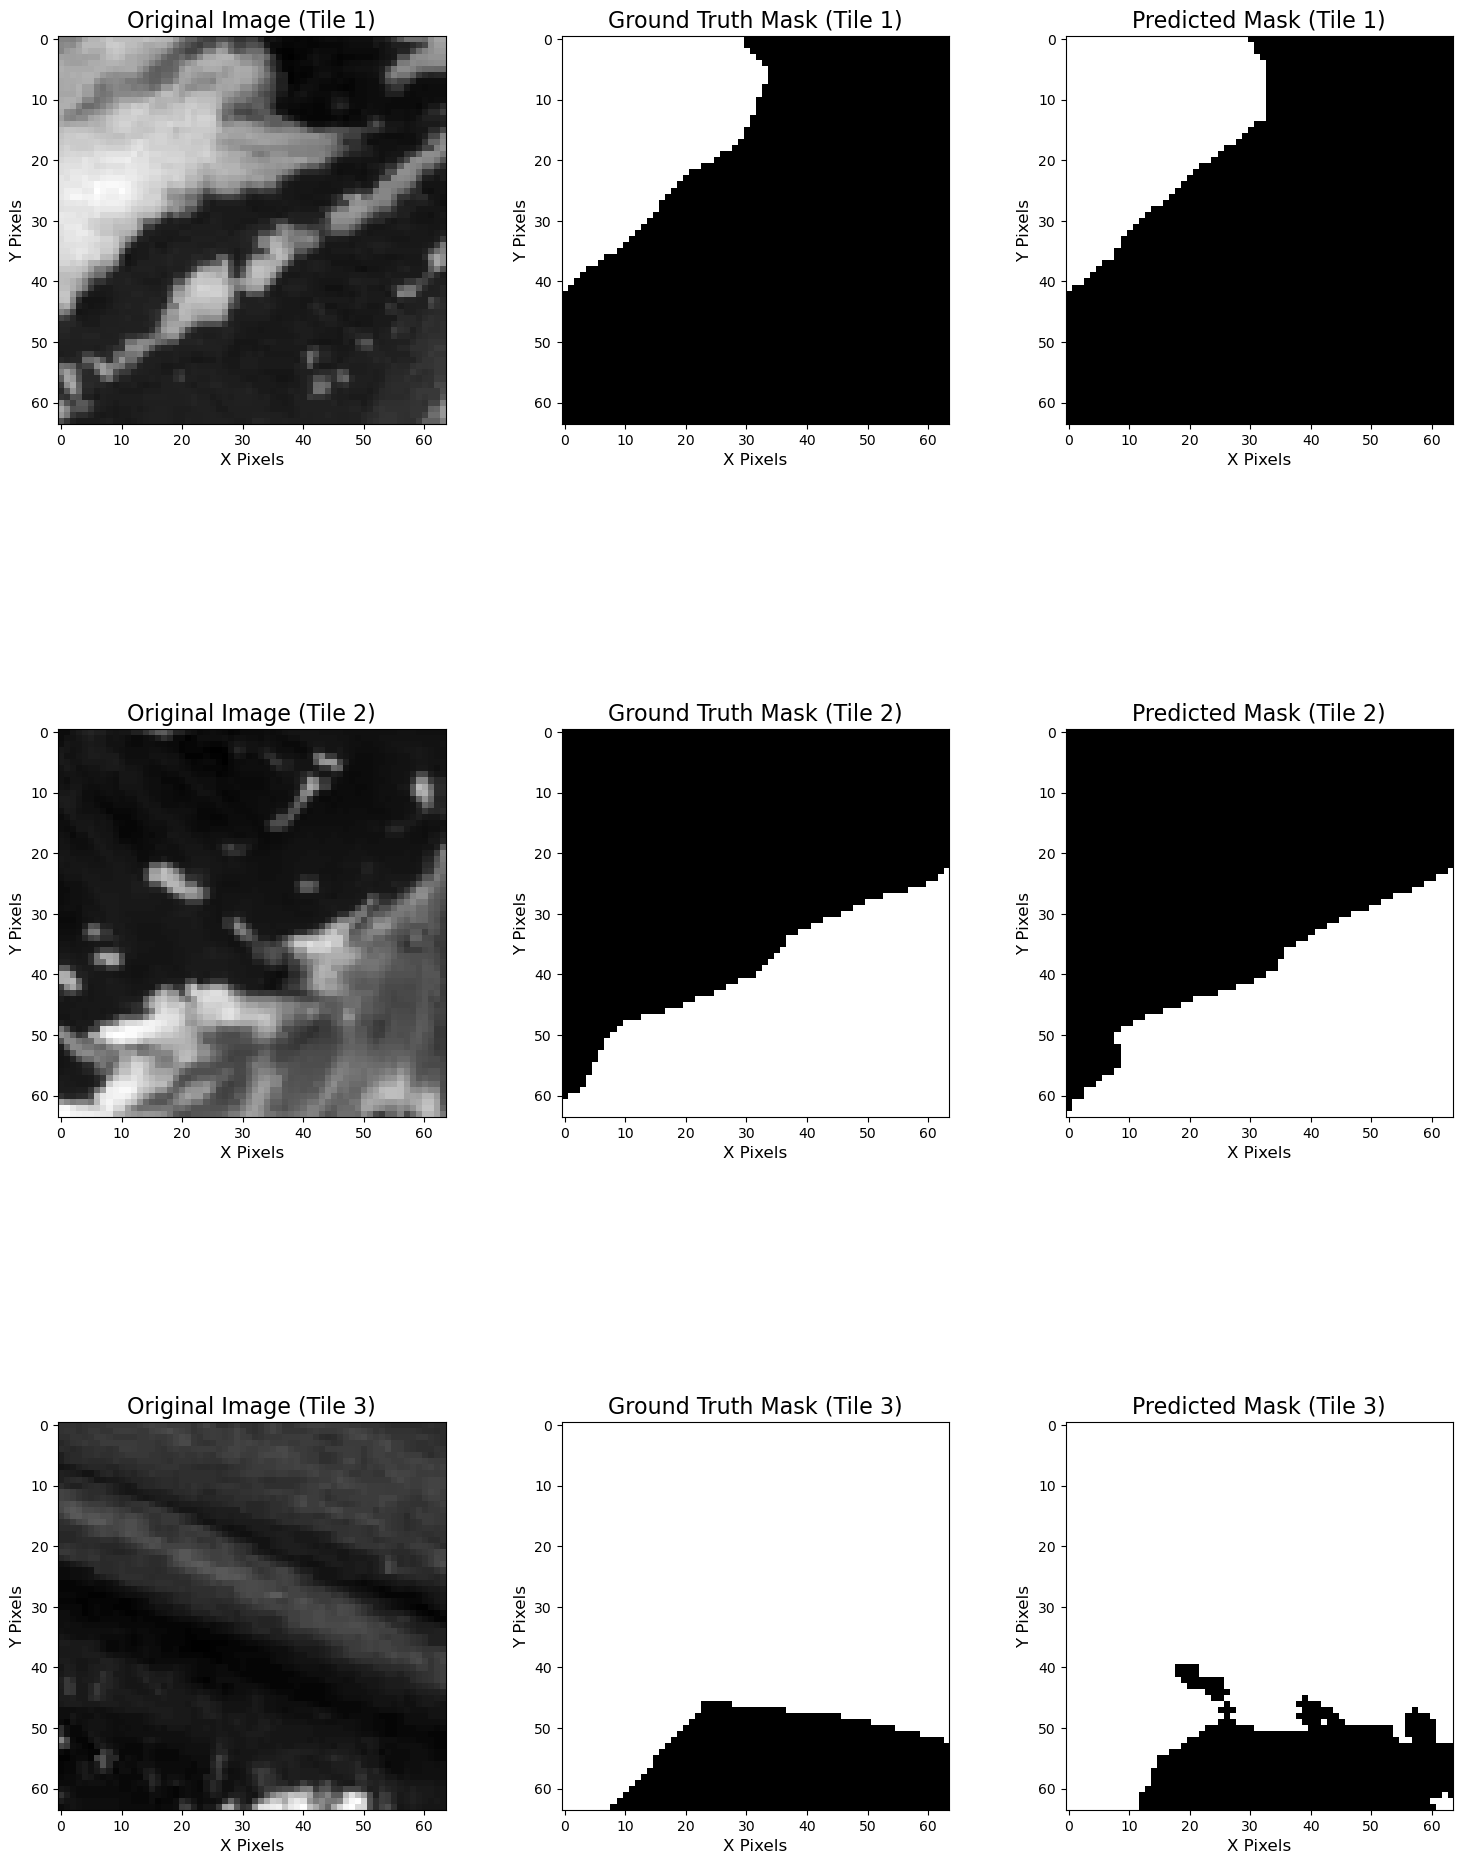

In [26]:
# Define the figure size and the spacing between subplots
plt.figure(figsize=(18, 24))  # Adjusted size for three rows
plt.subplots_adjust(wspace=0.3, hspace=0.5)  # Increased spacing between plots and rows

# Loop through the first three tiles in the test set
for i in range(3):
    test_image = X_test[i]
    ground_truth_image = np.argmax(y_test[i], axis=-1)  # Decategorize the mask
    predicted_mask = model.predict(np.expand_dims(test_image, axis=0))
    predicted_image = np.argmax(predicted_mask[0], axis=-1)  # Decategorize predicted mask

    # Original Image
    plt.subplot(3, 3, i * 3 + 1)
    plt.title(f"Original Image (Tile {i+1})", fontsize=16)
    plt.imshow(test_image[..., 0], cmap='gray')  # Show first channel only
    plt.xlabel("X Pixels", fontsize=12)
    plt.ylabel("Y Pixels", fontsize=12)

    # Ground Truth Mask
    plt.subplot(3, 3, i * 3 + 2)
    plt.title(f"Ground Truth Mask (Tile {i+1})", fontsize=16)
    plt.imshow(ground_truth_image, cmap='gray')
    plt.xlabel("X Pixels", fontsize=12)
    plt.ylabel("Y Pixels", fontsize=12)

    # Predicted Mask
    plt.subplot(3, 3, i * 3 + 3)
    plt.title(f"Predicted Mask (Tile {i+1})", fontsize=16)
    plt.imshow(predicted_image, cmap='gray')
    plt.xlabel("X Pixels", fontsize=12)
    plt.ylabel("Y Pixels", fontsize=12)

# Show the plot
plt.show()

In [27]:
from tensorflow.keras.models import load_model

# Load the model with custom objects
model_path = 'sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/sf/model/glavitu_all_area.h5'
# Load the model (no custom objects used)
model = load_model(model_path, compile=False)

# Print model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 18)]         0         []                            
                                                                                                  
 conv2d_24 (Conv2D)          (None, 64, 64, 64)           10432     ['input_2[0][0]']             
                                                                                                  
 batch_normalization_21 (Ba  (None, 64, 64, 64)           256       ['conv2d_24[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_14 (Activation)  (None, 64, 64, 64)           0         ['batch_normalization_21

In [28]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from rasterio.features import shapes
import fiona
from shapely.geometry import shape, mapping
import os

# Define paths
model_path = 'sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/sf/model/glavitu_all_area.h5'
raster_files = [
    'sarvesh/DATASETS_NORMALIZED/raster_satopanth_normalized.tif',
    'sarvesh/DATASETS_NORMALIZED/sikkim_chaudhary_255_final.tif',
    'sarvesh/DATASETS_NORMALIZED/KASHMIR_NORMALIZED_255_final.tif',
    'sarvesh/DATASETS_NORMALIZED/raster_cb__normalized.tif',
    'sarvesh/DATASETS_NORMALIZED/cb_vali_normalized_128.tif'
]
output_dir = 'sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/sf'

# Load the model
model = load_model(model_path, compile=False)

# Patch and overlap settings
patch_size = 64
overlap = 32
stride = patch_size - overlap

# Blending matrix
blend_matrix = np.ones((patch_size, patch_size))
for i in range(overlap):
    weight = (i + 1) / overlap
    blend_matrix[i, :] *= weight
    blend_matrix[-(i + 1), :] *= weight
    blend_matrix[:, i] *= weight
    blend_matrix[:, -(i + 1)] *= weight

# Process each raster file
for raster_file in raster_files:
    with rasterio.open(raster_file) as src:
        raster_data = src.read()
        raster_profile = src.profile
        transform = src.transform
        crs = src.crs

    # Transpose raster to (H, W, C)
    raster_data = np.transpose(raster_data, (1, 2, 0))
    height, width, channels = raster_data.shape

    # Pad raster
    pad_h = (stride - height % stride) % stride
    pad_w = (stride - width % stride) % stride
    raster_data_padded = np.pad(raster_data, ((0, pad_h), (0, pad_w), (0, 0)), mode='reflect')

    # Predict full raster via sliding window
    predicted_raster = np.zeros((raster_data_padded.shape[0], raster_data_padded.shape[1]), dtype=np.float32)
    weight_sum = np.zeros_like(predicted_raster)

    for i in range(0, raster_data_padded.shape[0] - patch_size + 1, stride):
        for j in range(0, raster_data_padded.shape[1] - patch_size + 1, stride):
            patch = raster_data_padded[i:i + patch_size, j:j + patch_size, :]
            patch = np.expand_dims(patch, axis=0)
            prediction = model.predict(patch, verbose=0)
            predicted_patch = np.argmax(prediction, axis=-1).squeeze()

            predicted_raster[i:i + patch_size, j:j + patch_size] += predicted_patch * blend_matrix
            weight_sum[i:i + patch_size, j:j + patch_size] += blend_matrix

    # Normalize and crop
    weight_sum[weight_sum == 0] = 1
    predicted_raster = (predicted_raster / weight_sum).astype(np.uint8)
    predicted_raster = predicted_raster[:height, :width]

    # Save predicted raster
    os.makedirs(output_dir, exist_ok=True)
    base_name = os.path.splitext(os.path.basename(raster_file))[0]
    predicted_raster_path = os.path.join(output_dir, f'{base_name}_cb_segnet.tif')

    raster_profile.update({
        'count': 1,
        'dtype': 'uint8',
        'compress': 'lzw',
        'nodata': 0
    })

    with rasterio.open(predicted_raster_path, 'w', **raster_profile) as dst:
        dst.write(predicted_raster, 1)

    print(f"Predicted raster saved: {predicted_raster_path}")

    # Convert raster to shapefile
    shapefile_path = os.path.join(output_dir, f'{base_name}_segnet_mask.shp')
    shapes_gen = shapes(predicted_raster, mask=predicted_raster > 0, transform=transform)

    schema = {
        'geometry': 'Polygon',
        'properties': {'value': 'int'}
    }

    with fiona.open(shapefile_path, 'w', driver='ESRI Shapefile', crs=crs, schema=schema) as shp:
        for geom, value in shapes_gen:
            shp.write({
                'geometry': mapping(shape(geom)),
                'properties': {'value': int(value)}
            })

    print(f"Shapefile saved: {shapefile_path}")

Predicted raster saved: sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/sf/raster_satopanth_normalized_cb_segnet.tif
Shapefile saved: sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/sf/raster_satopanth_normalized_segnet_mask.shp
Predicted raster saved: sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/sf/sikkim_chaudhary_255_final_cb_segnet.tif
Shapefile saved: sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/sf/sikkim_chaudhary_255_final_segnet_mask.shp
Predicted raster saved: sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/sf/KASHMIR_NORMALIZED_255_final_cb_segnet.tif
Shapefile saved: sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/sf/KASHMIR_NORMALIZED_255_final_segnet_mask.shp
Predicted raster saved: sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/sf/raster_cb__normalized_cb_segnet.tif
Shapefile saved: sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/sf/raster_cb__normalized_segnet_mask.shp
Predicted raster saved: sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/sf/cb_vali_normalized_12


=== Processing KASHMIR ===
Confusion Matrix:
[[23214065    49512]
 [  110295   506088]]
Overall Accuracy: 0.9933
Mean IoU: 0.8766
F1 Score: 0.9301
Recall: 0.9095
Precision: 0.9531
Cohen's Kappa: 0.8602

=== Processing SIKKIM ===
Confusion Matrix:
[[18702564    77487]
 [  107540   396421]]
Overall Accuracy: 0.9904
Mean IoU: 0.8360
F1 Score: 0.9029
Recall: 0.8912
Precision: 0.9154
Cohen's Kappa: 0.8059

=== Processing UTTRAKHAND ===
Confusion Matrix:
[[5919598  301988]
 [ 710289 2105625]]
Overall Accuracy: 0.8880
Mean IoU: 0.7647
F1 Score: 0.8637
Recall: 0.8496
Precision: 0.8837
Cohen's Kappa: 0.7281

=== Processing CHANDRA BHAGA BASIN ===
Confusion Matrix:
[[95007835   348390]
 [ 1494436 10500169]]
Overall Accuracy: 0.9828
Mean IoU: 0.9158
F1 Score: 0.9549
Recall: 0.9359
Precision: 0.9762
Cohen's Kappa: 0.9097

=== Processing CB VALIDATION ===
Confusion Matrix:
[[20221064   174474]
 [  877461  1658665]]
Overall Accuracy: 0.9541
Mean IoU: 0.7812
F1 Score: 0.8669
Recall: 0.8227
Precision

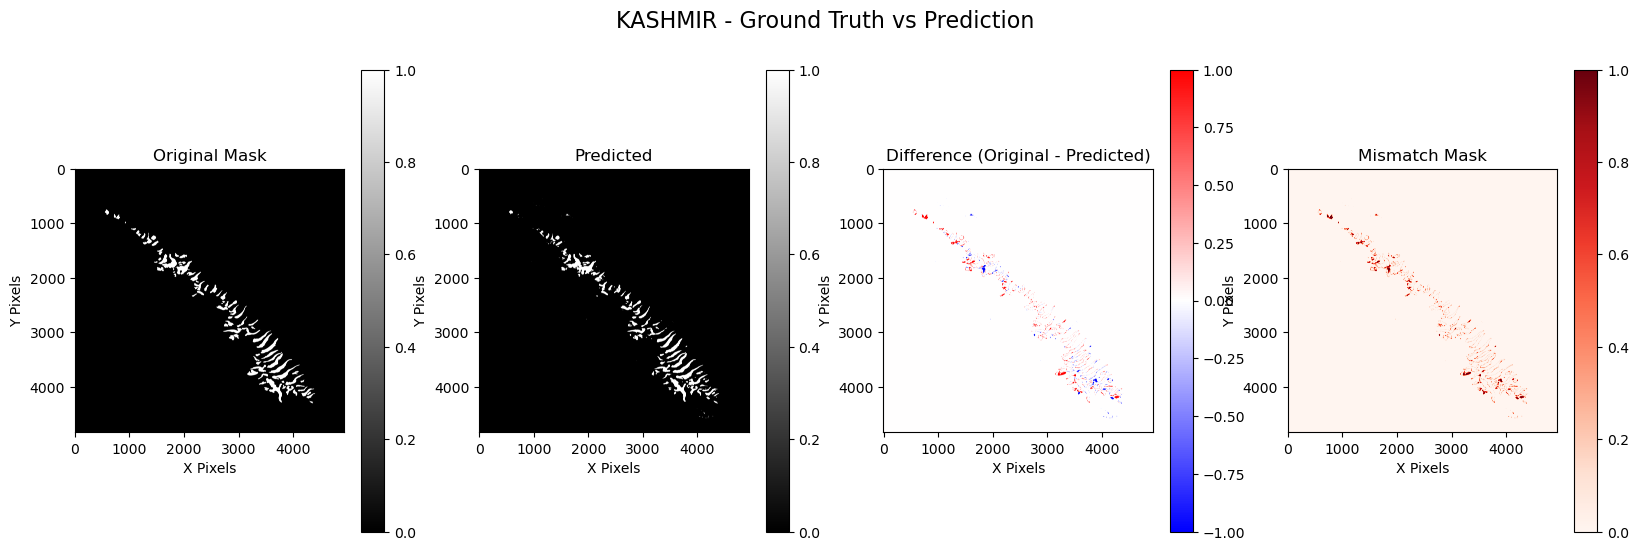

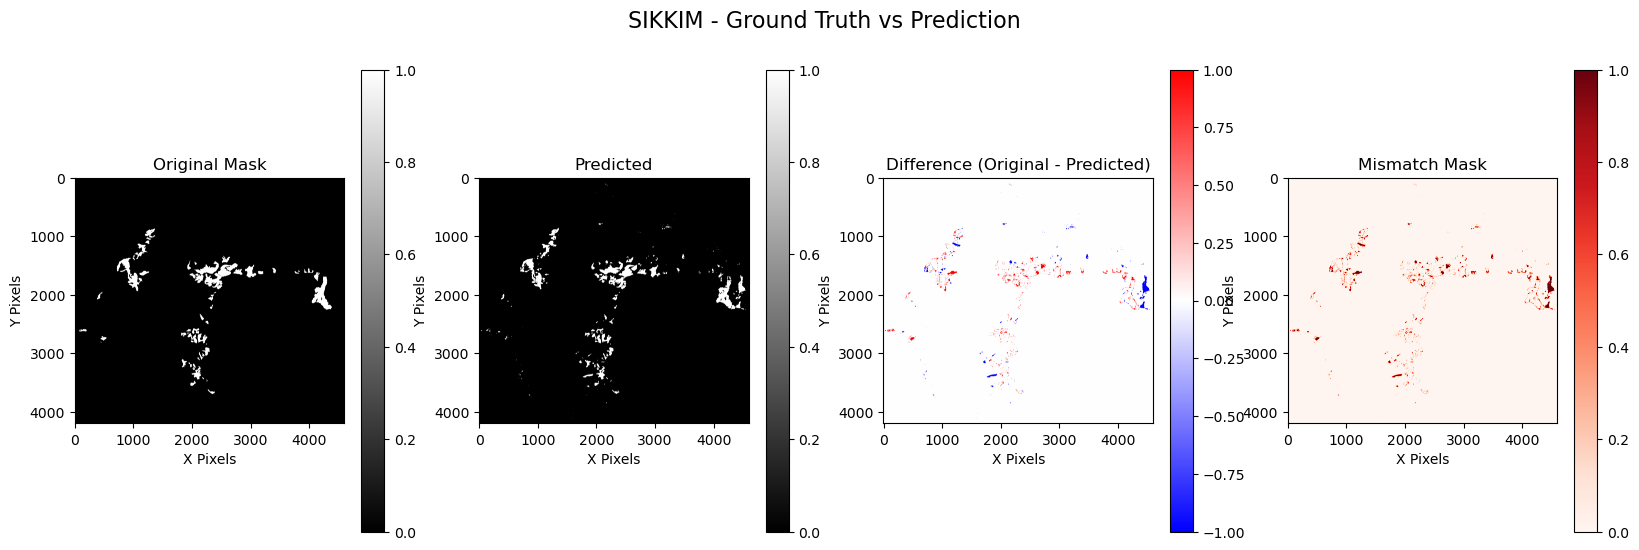

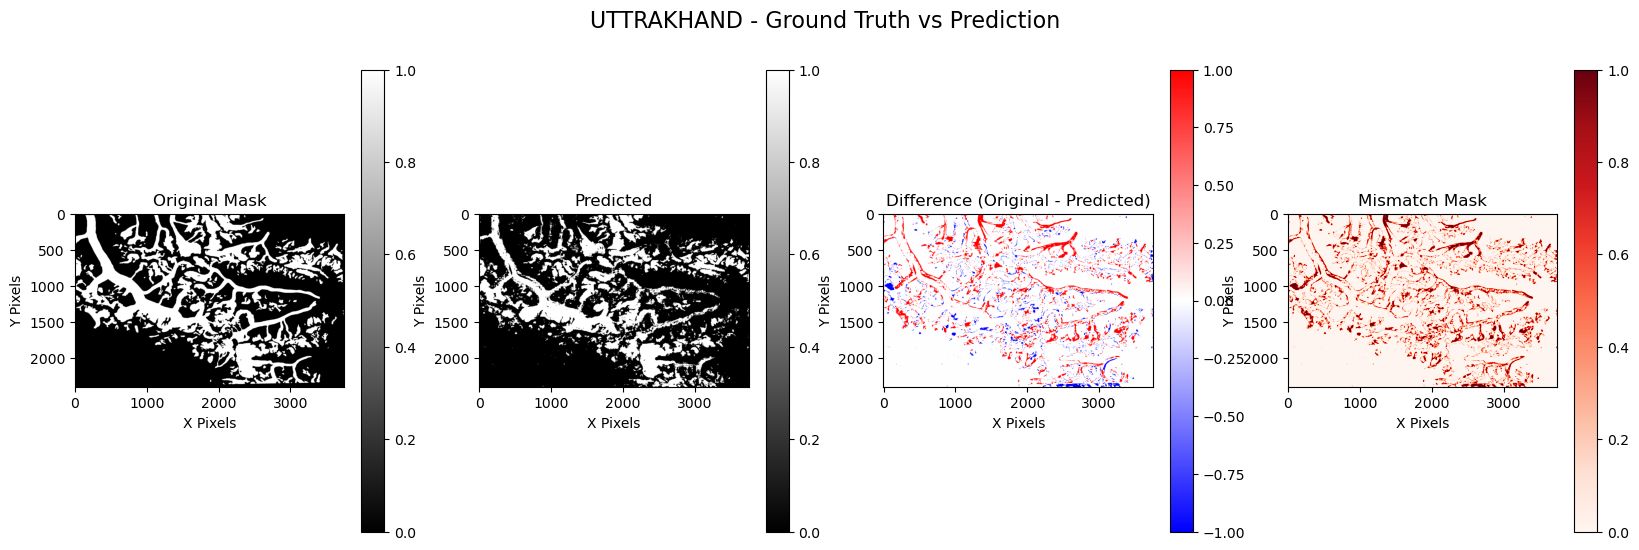

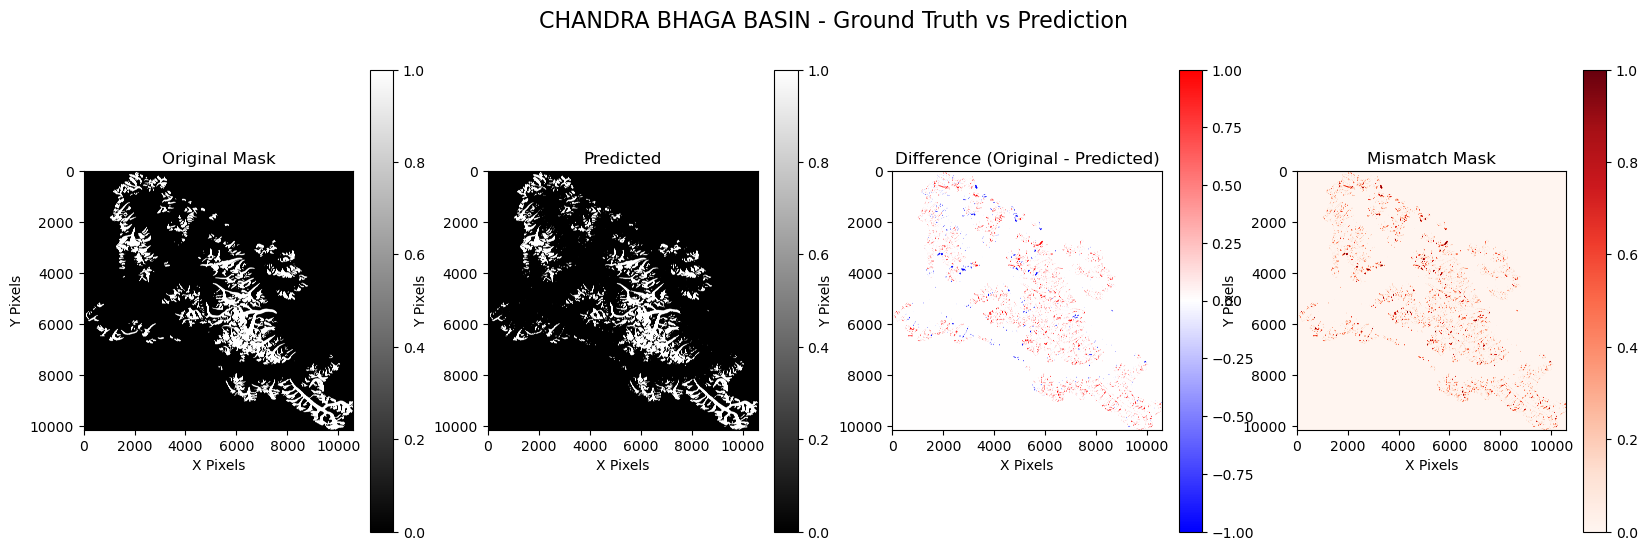

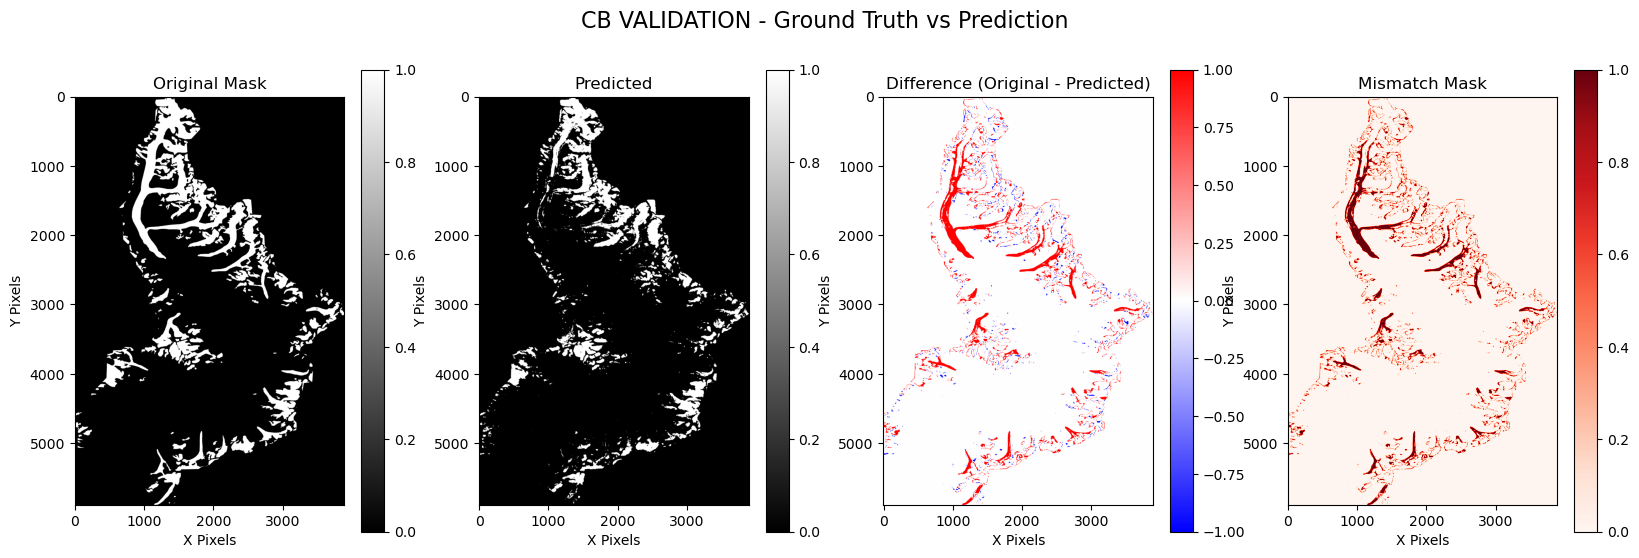

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, accuracy_score, jaccard_score, 
    f1_score, recall_score, precision_score, cohen_kappa_score
)
from rasterio.warp import reproject, Resampling
import os

# List of mask and predicted raster paths
data_pairs = [
    {
        'mask': 'sarvesh/new_layers_/mask_reprojected/KASHMIR_NORMALIZED_255_finalkasmircomplete_mask_reprojected.tif',
        'predicted': 'sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/sf/KASHMIR_NORMALIZED_255_final_cb_segnet.tif',
        'label': 'KASHMIR'
    },
    {
        'mask': 'sarvesh/DATASETS_NORMALIZED/sikkim_mask.tif',
        'predicted': 'sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/sf/sikkim_chaudhary_255_final_cb_segnet.tif',
        'label': 'SIKKIM'
    },
    {
        'mask': 'sarvesh/chandrabasin/dataset/new/masklayersato.tif',
        'predicted': 'sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/sf/raster_satopanth_normalized_cb_segnet.tif',
        'label': 'UTTRAKHAND'
    },
    {
        'mask': 'sarvesh/new_layers_/mask_reprojected/raster_cb__normalized_new_mask_reprojected.tif',
        'predicted': 'sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/sf/raster_cb__normalized_cb_segnet.tif',
        'label': 'CHANDRA BHAGA BASIN'
    },
    {
        'mask': 'sarvesh/DATASETS_NORMALIZED/CB_VALIDATION_MASK.tif',
        'predicted': 'sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/sf/cb_vali_normalized_128_cb_segnet.tif',
        'label': 'CB VALIDATION'
    },
]

# Loop over each pair
for pair in data_pairs:
    print(f"\n=== Processing {pair['label']} ===")

    # Load original mask
    with rasterio.open(pair['mask']) as src:
        original_mask = src.read(1)
        original_profile = src.profile

    # Load predicted raster
    with rasterio.open(pair['predicted']) as src:
        predicted_raster = src.read(1)

    # Resample predicted raster to match original mask dimensions
    resampled_predicted = np.empty_like(original_mask)
    with rasterio.open(pair['predicted']) as src_pred:
        reproject(
            source=rasterio.band(src_pred, 1),
            destination=resampled_predicted,
            src_transform=src_pred.transform,
            src_crs=src_pred.crs,
            dst_transform=original_profile['transform'],
            dst_crs=original_profile['crs'],
            resampling=Resampling.nearest
        )

    # Handle no-data masking
    nodata_val = original_profile.get('nodata')
    if nodata_val is not None:
        valid_mask = original_mask != nodata_val
    else:
        valid_mask = np.ones_like(original_mask, dtype=bool)

    # Filter only valid pixels
    original_mask_valid = original_mask[valid_mask]
    resampled_predicted_valid = resampled_predicted[valid_mask]

    # Compute metrics
    conf_matrix = confusion_matrix(original_mask_valid, resampled_predicted_valid)
    accuracy = accuracy_score(original_mask_valid, resampled_predicted_valid)
    iou = jaccard_score(original_mask_valid, resampled_predicted_valid, average='macro')
    f1 = f1_score(original_mask_valid, resampled_predicted_valid, average='macro')
    recall = recall_score(original_mask_valid, resampled_predicted_valid, average='macro')
    precision = precision_score(original_mask_valid, resampled_predicted_valid, average='macro')
    kappa = cohen_kappa_score(original_mask_valid, resampled_predicted_valid)

    # Print metrics
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Mean IoU: {iou:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")

    # Visualize - create new figure for each dataset
    fig, axes = plt.subplots(1, 4, figsize=(20, 6))
    fig.suptitle(f"{pair['label']} - Ground Truth vs Prediction", fontsize=16)

    # Original Mask
    im0 = axes[0].imshow(original_mask, cmap='gray')
    axes[0].set_title("Original Mask")
    plt.colorbar(im0, ax=axes[0])
    
    # Predicted
    im1 = axes[1].imshow(resampled_predicted, cmap='gray')
    axes[1].set_title("Predicted")
    plt.colorbar(im1, ax=axes[1])
    
    # Difference
    diff = original_mask.astype(int) - resampled_predicted.astype(int)
    im2 = axes[2].imshow(diff, cmap='bwr', vmin=-1, vmax=1)
    axes[2].set_title("Difference (Original - Predicted)")
    plt.colorbar(im2, ax=axes[2])
    
    # Difference Mask
    diff_mask = (original_mask != resampled_predicted).astype(int)
    im3 = axes[3].imshow(diff_mask, cmap='Reds')
    axes[3].set_title("Mismatch Mask")
    plt.colorbar(im3, ax=axes[3])

    for ax in axes:
        ax.set_xlabel("X Pixels")
        ax.set_ylabel("Y Pixels")

# Show all plots at once
plt.show()


=== Processing KASHMIR ===
Confusion Matrix:
[[23263577        0]
 [  110295   506088]]
Overall Accuracy: 0.9954
Mean IoU: 0.9082
F1 Score: 0.9497
Recall: 0.9105
Precision: 0.9976
Cohen's Kappa: 0.8994

=== Processing SIKKIM ===
Confusion Matrix:
[[18780051        0]
 [  107540   396421]]
Overall Accuracy: 0.9944
Mean IoU: 0.8905
F1 Score: 0.9389
Recall: 0.8933
Precision: 0.9972
Cohen's Kappa: 0.8777

=== Processing UTTRAKHAND ===
Confusion Matrix:
[[6221586       0]
 [ 710289 2105625]]
Overall Accuracy: 0.9214
Mean IoU: 0.8226
F1 Score: 0.9008
Recall: 0.8739
Precision: 0.9488
Cohen's Kappa: 0.8032

=== Processing CHANDRA BHAGA BASIN ===
Confusion Matrix:
[[95356225        0]
 [ 1494436 10500169]]
Overall Accuracy: 0.9861
Mean IoU: 0.9300
F1 Score: 0.9629
Recall: 0.9377
Precision: 0.9923
Cohen's Kappa: 0.9258

=== Processing CB VALIDATION ===
Confusion Matrix:
[[20395538        0]
 [  877461  1658665]]
Overall Accuracy: 0.9617
Mean IoU: 0.8064
F1 Score: 0.8849
Recall: 0.8270
Precision

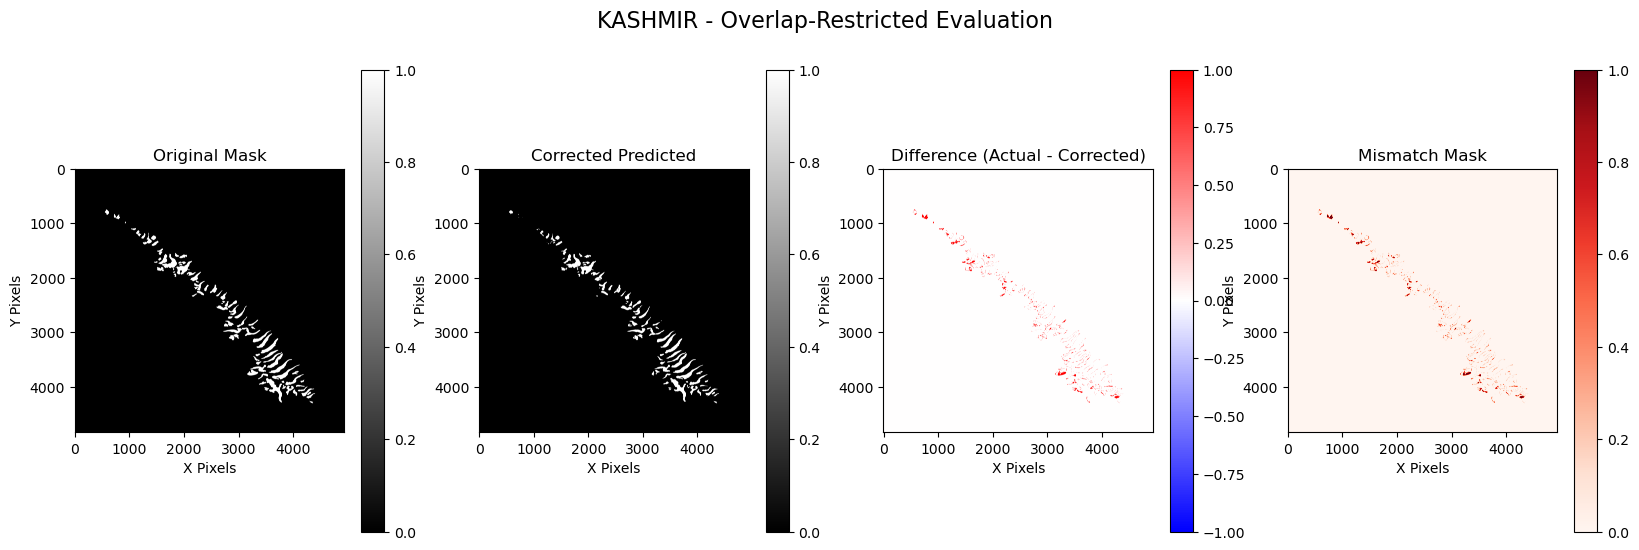

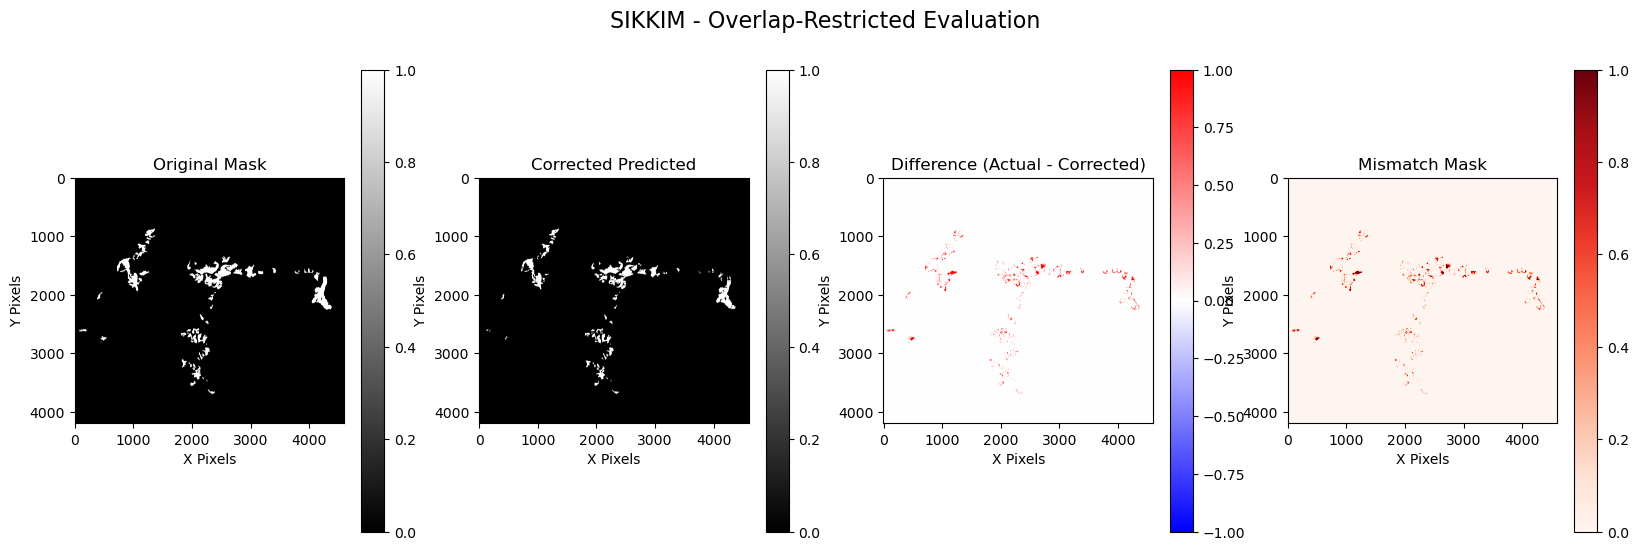

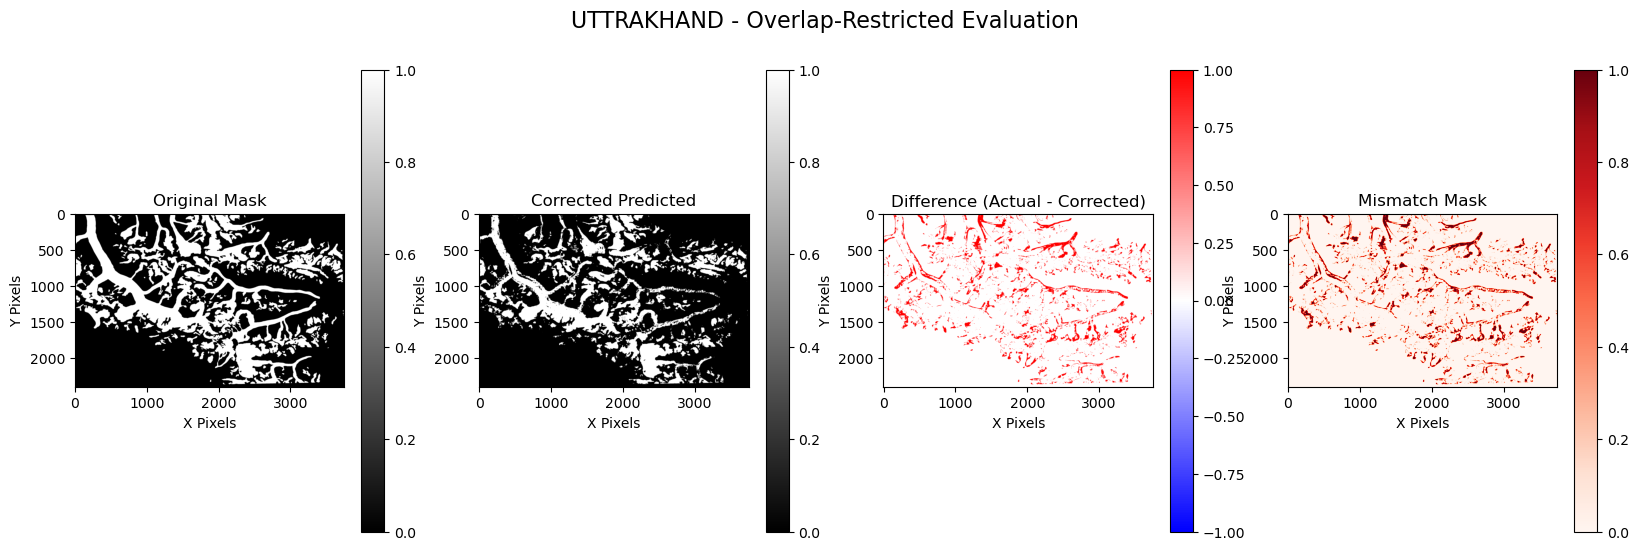

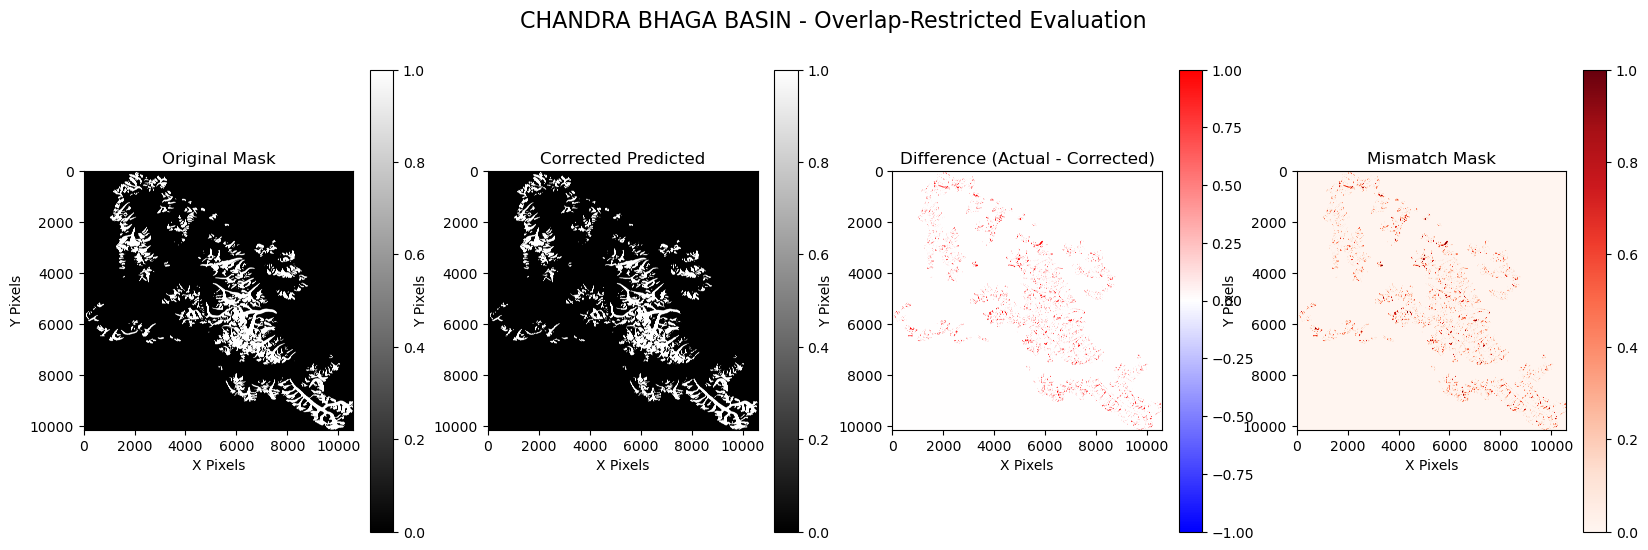

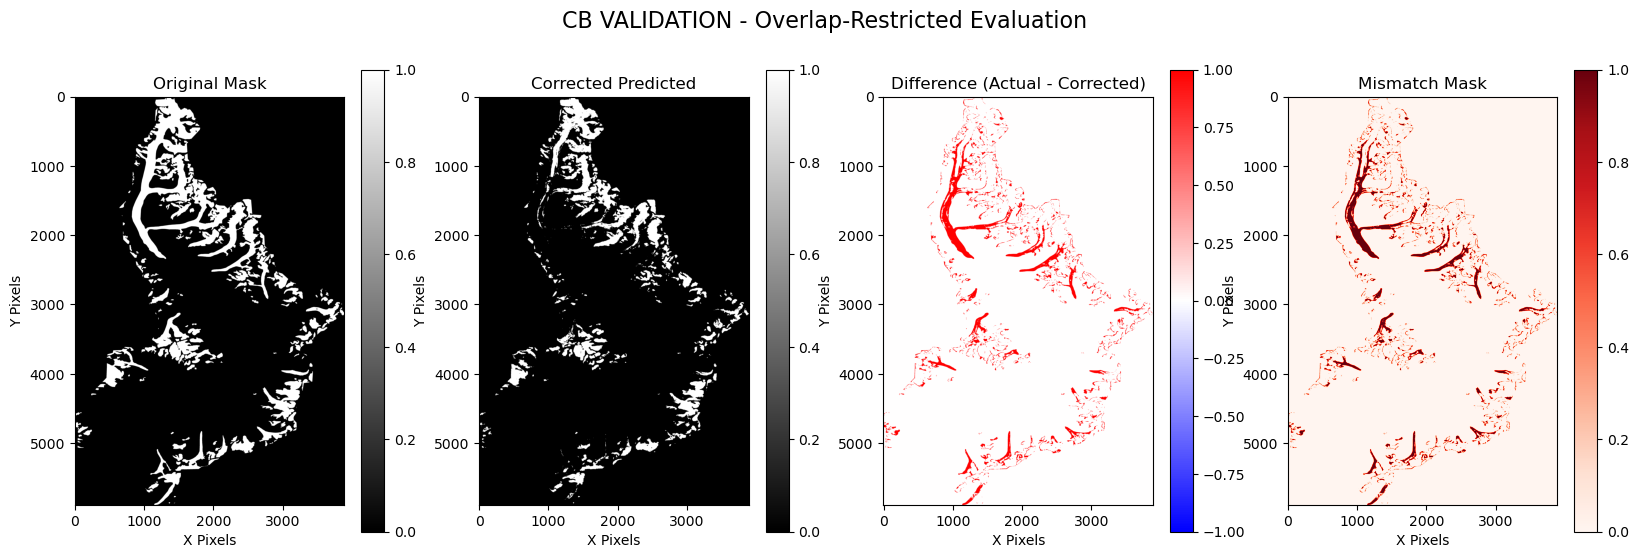

In [2]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, accuracy_score, jaccard_score, 
    f1_score, recall_score, precision_score, cohen_kappa_score
)
from rasterio.warp import reproject, Resampling

# List of mask and predicted raster paths
data_pairs = [
    {
        'mask': 'sarvesh/new_layers_/mask_reprojected/KASHMIR_NORMALIZED_255_finalkasmircomplete_mask_reprojected.tif',
        'predicted': 'sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/sf/KASHMIR_NORMALIZED_255_final_cb_segnet.tif',
        'label': 'KASHMIR'
    },
    {
        'mask': 'sarvesh/DATASETS_NORMALIZED/sikkim_mask.tif',
        'predicted': 'sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/sf/sikkim_chaudhary_255_final_cb_segnet.tif',
        'label': 'SIKKIM'
    },
    {
        'mask': 'sarvesh/chandrabasin/dataset/new/masklayersato.tif',
        'predicted': 'sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/sf/raster_satopanth_normalized_cb_segnet.tif',
        'label': 'UTTRAKHAND'
    },
    {
        'mask': 'sarvesh/new_layers_/mask_reprojected/raster_cb__normalized_new_mask_reprojected.tif',
        'predicted': 'sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/sf/raster_cb__normalized_cb_segnet.tif',
        'label': 'CHANDRA BHAGA BASIN'
    },
    {
        'mask': 'sarvesh/DATASETS_NORMALIZED/CB_VALIDATION_MASK.tif',
        'predicted': 'sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/sf/cb_vali_normalized_128_cb_segnet.tif',
        'label': 'CB VALIDATION'
    },
]

for pair in data_pairs:
    print(f"\n=== Processing {pair['label']} ===")

    # Load actual mask
    with rasterio.open(pair['mask']) as src:
        original_mask = src.read(1)
        original_profile = src.profile

    # Load predicted raster
    with rasterio.open(pair['predicted']) as src:
        predicted_raster = src.read(1)

    # Resample predicted to match ground truth mask
    resampled_predicted = np.empty_like(original_mask)
    with rasterio.open(pair['predicted']) as src_pred:
        reproject(
            source=rasterio.band(src_pred, 1),
            destination=resampled_predicted,
            src_transform=src_pred.transform,
            src_crs=src_pred.crs,
            dst_transform=original_profile['transform'],
            dst_crs=original_profile['crs'],
            resampling=Resampling.nearest
        )

    # Handle no-data masking
    nodata_val = original_profile.get('nodata')
    if nodata_val is not None:
        valid_mask = original_mask != nodata_val
    else:
        valid_mask = np.ones_like(original_mask, dtype=bool)

    # === Key step: Remove predictions outside actual mask ===
    # Wherever actual mask is 0, predicted should be set to 0
    corrected_predicted = resampled_predicted.copy()
    corrected_predicted[original_mask == 0] = 0

    # Filter only valid pixels
    original_mask_valid = original_mask[valid_mask]
    corrected_predicted_valid = corrected_predicted[valid_mask]

    # === Accuracy metrics ===
    conf_matrix = confusion_matrix(original_mask_valid, corrected_predicted_valid)
    accuracy = accuracy_score(original_mask_valid, corrected_predicted_valid)
    iou = jaccard_score(original_mask_valid, corrected_predicted_valid, average='macro')
    f1 = f1_score(original_mask_valid, corrected_predicted_valid, average='macro')
    recall = recall_score(original_mask_valid, corrected_predicted_valid, average='macro')
    precision = precision_score(original_mask_valid, corrected_predicted_valid, average='macro')
    kappa = cohen_kappa_score(original_mask_valid, corrected_predicted_valid)

    # Print results
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Mean IoU: {iou:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")

    # === Visualization ===
    fig, axes = plt.subplots(1, 4, figsize=(20, 6))
    fig.suptitle(f"{pair['label']} - Overlap-Restricted Evaluation", fontsize=16)

    # Original Mask
    im0 = axes[0].imshow(original_mask, cmap='gray')
    axes[0].set_title("Original Mask")
    plt.colorbar(im0, ax=axes[0])

    # Corrected Prediction
    im1 = axes[1].imshow(corrected_predicted, cmap='gray')
    axes[1].set_title("Corrected Predicted")
    plt.colorbar(im1, ax=axes[1])

    # Difference
    diff = original_mask.astype(int) - corrected_predicted.astype(int)
    im2 = axes[2].imshow(diff, cmap='bwr', vmin=-1, vmax=1)
    axes[2].set_title("Difference (Actual - Corrected)")
    plt.colorbar(im2, ax=axes[2])

    # Mismatch
    mismatch = (original_mask != corrected_predicted).astype(int)
    im3 = axes[3].imshow(mismatch, cmap='Reds')
    axes[3].set_title("Mismatch Mask")
    plt.colorbar(im3, ax=axes[3])

    for ax in axes:
        ax.set_xlabel("X Pixels")
        ax.set_ylabel("Y Pixels")

plt.show()

In [1]:
import rasterio
import numpy as np
from sklearn.metrics import (
    confusion_matrix, accuracy_score, jaccard_score, 
    f1_score, recall_score, precision_score, cohen_kappa_score
)
from rasterio.warp import reproject, Resampling

# List of mask and predicted raster paths
data_pairs = [
    {
        'mask': 'sarvesh/DATASETS_NORMALIZED/KASHMIR_MASK.tif',
        'predicted': 'sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/sf/KASHMIR_NORMALIZED_255_final_cb_segnet.tif',
        'label': 'KASHMIR'
    },
    {
        'mask': 'sarvesh/DATASETS_NORMALIZED/sikkim_mask.tif',
        'predicted': 'sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/sf/sikkim_chaudhary_255_final_cb_segnet.tif',
        'label': 'SIKKIM'
    },
    {
        'mask': 'sarvesh/chandrabasin/dataset/new/masklayersato.tif',
        'predicted': 'sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/sf/raster_satopanth_normalized_cb_segnet.tif',
        'label': 'UTTRAKHAND'
    },
    {
        'mask': 'sarvesh/chandrabasin/cb_dataset/dataset-9999-limit/cb_glacier_raster.tif',
        'predicted': 'sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/sf/raster_cb__normalized_cb_segnet.tif',
        'label': 'CHANDRA BHAGA BASIN'
    },
    {
        'mask': 'sarvesh/DATASETS_NORMALIZED/CB_VALIDATION_MASK.tif',
        'predicted': 'sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/sf/cb_vali_normalized_128_cb_segnet.tif',
        'label': 'CB VALIDATION'
    },
]

# Loop over each pair
for pair in data_pairs:
    print(f"\n=== Processing {pair['label']} ===")

    # Load original mask
    with rasterio.open(pair['mask']) as src:
        original_mask = src.read(1)
        original_profile = src.profile

    # Load predicted raster
    with rasterio.open(pair['predicted']) as src:
        predicted_raster = src.read(1)

    # Resample predicted raster to match original mask dimensions
    resampled_predicted = np.empty_like(original_mask)
    with rasterio.open(pair['predicted']) as src_pred:
        reproject(
            source=rasterio.band(src_pred, 1),
            destination=resampled_predicted,
            src_transform=src_pred.transform,
            src_crs=src_pred.crs,
            dst_transform=original_profile['transform'],
            dst_crs=original_profile['crs'],
            resampling=Resampling.nearest
        )

    # Handle no-data masking
    nodata_val = original_profile.get('nodata')
    valid_mask = (original_mask != nodata_val) if nodata_val is not None else np.ones_like(original_mask, dtype=bool)

    # Filter only valid pixels
    y_true = original_mask[valid_mask].astype(int).flatten()
    y_pred = resampled_predicted[valid_mask].astype(int).flatten()

    # If one class is missing, handle zero_division warnings gracefully
    labels = np.union1d(y_true, y_pred)

    # Compute metrics
    conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)
    accuracy = accuracy_score(y_true, y_pred)
    iou = jaccard_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    kappa = cohen_kappa_score(y_true, y_pred)

    # Print results
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Mean IoU: {iou:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")



=== Processing KASHMIR ===
Confusion Matrix:
[[     0      0]
 [110295 506088]]
Overall Accuracy: 0.8211
Mean IoU: 0.4105
F1 Score: 0.4509
Recall: 0.4105
Precision: 0.5000
Cohen's Kappa: 0.0000

=== Processing SIKKIM ===
Confusion Matrix:
[[18702564    77487]
 [  107540   396421]]
Overall Accuracy: 0.9904
Mean IoU: 0.8360
F1 Score: 0.9029
Recall: 0.8912
Precision: 0.9154
Cohen's Kappa: 0.8059

=== Processing UTTRAKHAND ===
Confusion Matrix:
[[5919598  301988]
 [ 710289 2105625]]
Overall Accuracy: 0.8880
Mean IoU: 0.7647
F1 Score: 0.8637
Recall: 0.8496
Precision: 0.8837
Cohen's Kappa: 0.7281

=== Processing CHANDRA BHAGA BASIN ===
Confusion Matrix:
[[       0        0]
 [ 1494436 10500169]]
Overall Accuracy: 0.8754
Mean IoU: 0.4377
F1 Score: 0.4668
Recall: 0.4377
Precision: 0.5000
Cohen's Kappa: 0.0000

=== Processing CB VALIDATION ===
Confusion Matrix:
[[20221064   174474]
 [  877461  1658665]]
Overall Accuracy: 0.9541
Mean IoU: 0.7812
F1 Score: 0.8669
Recall: 0.8227
Precision: 0.9316

Input image shape: (1, 64, 64, 18)
Predictions shape: (1, 64, 64, 2)
Class index: 1


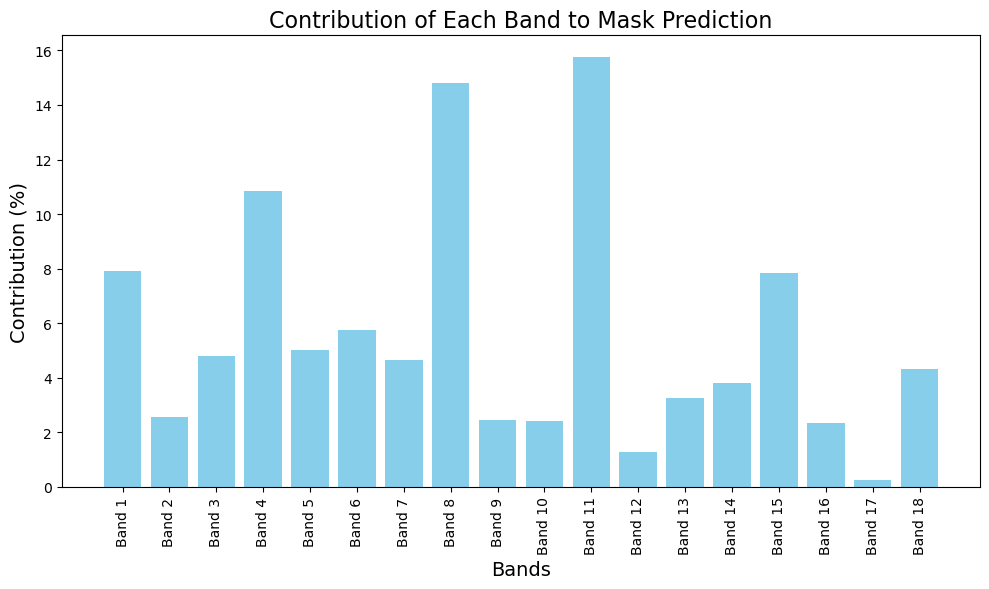

Band 1: 7.90% contribution
Band 2: 2.56% contribution
Band 3: 4.79% contribution
Band 4: 10.85% contribution
Band 5: 5.00% contribution
Band 6: 5.74% contribution
Band 7: 4.65% contribution
Band 8: 14.80% contribution
Band 9: 2.44% contribution
Band 10: 2.40% contribution
Band 11: 15.77% contribution
Band 12: 1.28% contribution
Band 13: 3.26% contribution
Band 14: 3.81% contribution
Band 15: 7.84% contribution
Band 16: 2.35% contribution
Band 17: 0.23% contribution
Band 18: 4.33% contribution


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

# Select a random test image
test_image_number = random.randint(0, len(X_test) - 1)
test_image = X_test[test_image_number]

# Ensure the input image has the correct shape
input_image = tf.convert_to_tensor(np.expand_dims(test_image, axis=0), dtype=tf.float32)
print(f"Input image shape: {input_image.shape}")  # Should print (1, 64, 64, 18)

# Get model predictions
predictions = model(input_image)
print(f"Predictions shape: {predictions.shape}")  # Should print (1, 64, 64, num_classes)

# Choose the class index (0 or 1) to analyze the gradients for
class_index = 1  # For example, class 1 (you can change to 0 to analyze the other class)
print(f"Class index: {class_index}")

# Initialize a GradientTape to compute gradients
with tf.GradientTape() as tape:
    tape.watch(input_image)  # Watch the input image for gradients
    predictions = model(input_image)
    class_predictions = predictions[0, :, :, class_index]  # Select the predicted class map

# Compute the gradients of the predicted class with respect to each input band (channel)
grads = tape.gradient(class_predictions, input_image)

# Calculate the mean gradient for each band (across height and width)
mean_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()

# Normalize the gradients to calculate contributions as percentages
total_grad = np.sum(np.abs(mean_grads))
contributions = (np.abs(mean_grads) / total_grad) * 100  # Percentage contribution of each band

# Plot the contributions of each band
plt.figure(figsize=(10, 6))
bands = [f'Band {i+1}' for i in range(18)]
plt.bar(bands, contributions, color='skyblue')
plt.title('Contribution of Each Band to Mask Prediction', fontsize=16)
plt.xlabel('Bands', fontsize=14)
plt.ylabel('Contribution (%)', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Print the percentage contribution of each band
for i, contribution in enumerate(contributions):
    print(f"Band {i+1}: {contribution:.2f}% contribution")

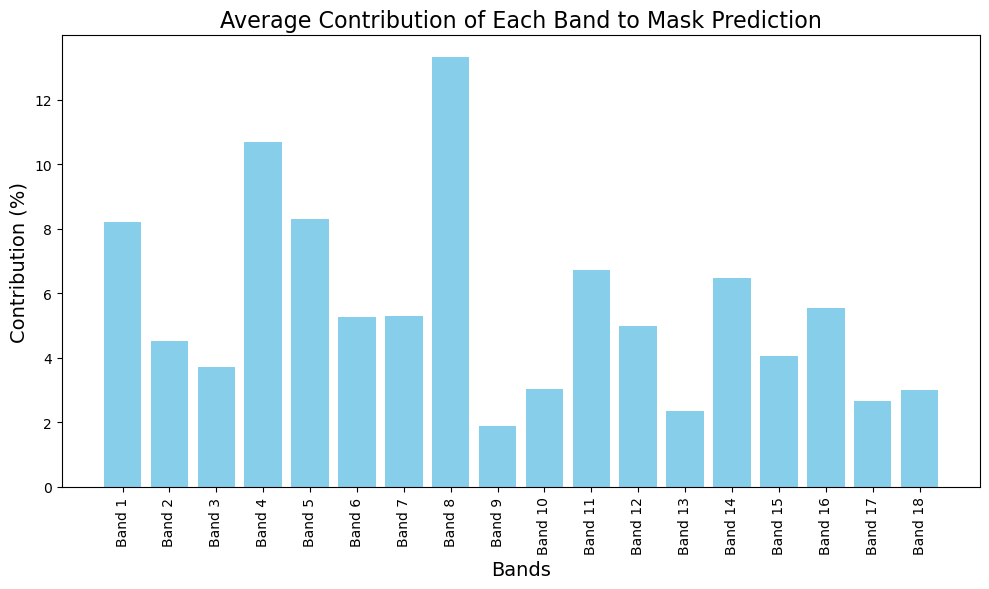

Band 1: 8.20% contribution
Band 2: 4.51% contribution
Band 3: 3.73% contribution
Band 4: 10.67% contribution
Band 5: 8.29% contribution
Band 6: 5.28% contribution
Band 7: 5.31% contribution
Band 8: 13.33% contribution
Band 9: 1.89% contribution
Band 10: 3.02% contribution
Band 11: 6.72% contribution
Band 12: 5.00% contribution
Band 13: 2.35% contribution
Band 14: 6.46% contribution
Band 15: 4.06% contribution
Band 16: 5.54% contribution
Band 17: 2.66% contribution
Band 18: 3.00% contribution


In [31]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

all_contributions = []

for test_image in X_test:
    input_image = tf.convert_to_tensor(np.expand_dims(test_image, axis=0), dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(input_image)
        predictions = model(input_image)
        class_predictions = predictions[0, :, :, class_index]  

    grads = tape.gradient(class_predictions, input_image)
    mean_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
    
    total_grad = np.sum(np.abs(mean_grads))

    if total_grad == 0:
        contributions = np.zeros_like(mean_grads)  # Handle zero division safely
    else:
        contributions = (np.abs(mean_grads) / total_grad) * 100  

    all_contributions.append(contributions)

# Compute average contribution across all patches
avg_contributions = np.mean(all_contributions, axis=0)

# Plot
plt.figure(figsize=(10, 6))
bands = [f'Band {i+1}' for i in range(len(avg_contributions))]
plt.bar(bands, avg_contributions, color='skyblue')
plt.title('Average Contribution of Each Band to Mask Prediction', fontsize=16)
plt.xlabel('Bands', fontsize=14)
plt.ylabel('Contribution (%)', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Print the percentage contribution of each band
for i, contribution in enumerate(avg_contributions):
    print(f"Band {i+1}: {contribution:.2f}% contribution")

In [32]:
import rasterio
import numpy as np
import os

# Input raster file paths
raster_files = [
    "sarvesh/DATASETS_NORMALIZED/raster_cb__normalized.tif",
    "sarvesh/DATASETS_NORMALIZED/cb_vali_normalized_128.tif",
    "sarvesh/DATASETS_NORMALIZED/rasters/KASMIR_255_CLIP.tif",
    "sarvesh/DATASETS_NORMALIZED/rasters/satopanth_255_clip.tif",
    "sarvesh/DATASETS_NORMALIZED/rasters/sikkim_255_clip.tif",
    "sarvesh/DATASETS_NORMALIZED/raster_satopanth_normalized.tif",
    "sarvesh/DATASETS_NORMALIZED/sikkim_chaudhary_255_final.tif",
    "sarvesh/DATASETS_NORMALIZED/KASHMIR_NORMALIZED_255_final.tif"
]

# Output directory for filtered rasters
output_dir = "sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/top6band"
os.makedirs(output_dir, exist_ok=True)

# Top 6 contributing bands (1-based indices)
top_6_bands = [8, 4, 5, 1, 11, 14]

# Process each raster file
for raster_path in raster_files:
    with rasterio.open(raster_path) as src:
        num_bands = src.count
        selected_bands = [b for b in top_6_bands if b <= num_bands]

        # Read and stack the selected bands
        selected_data = np.stack([src.read(b) for b in selected_bands])

        # Output file name
        output_filename = os.path.join(
            output_dir,
            os.path.basename(raster_path).replace(".tif", "_6band.tif")
        )

        # Write filtered raster
        with rasterio.open(
            output_filename, 'w', driver='GTiff',
            height=src.height, width=src.width,
            count=len(selected_bands), dtype=src.dtypes[0],
            crs=src.crs, transform=src.transform
        ) as dst:
            dst.write(selected_data)

        print(f"Processed: {raster_path} → Saved: {output_filename}")

print("Top 6 band filtering complete!")

Processed: sarvesh/DATASETS_NORMALIZED/raster_cb__normalized.tif → Saved: sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/top6band/raster_cb__normalized_6band.tif
Processed: sarvesh/DATASETS_NORMALIZED/cb_vali_normalized_128.tif → Saved: sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/top6band/cb_vali_normalized_128_6band.tif
Processed: sarvesh/DATASETS_NORMALIZED/rasters/KASMIR_255_CLIP.tif → Saved: sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/top6band/KASMIR_255_CLIP_6band.tif
Processed: sarvesh/DATASETS_NORMALIZED/rasters/satopanth_255_clip.tif → Saved: sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/top6band/satopanth_255_clip_6band.tif
Processed: sarvesh/DATASETS_NORMALIZED/rasters/sikkim_255_clip.tif → Saved: sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/top6band/sikkim_255_clip_6band.tif
Processed: sarvesh/DATASETS_NORMALIZED/raster_satopanth_normalized.tif → Saved: sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/top6band/raster_satopanth_norma

In [33]:
import os
import numpy as np
import rasterio
from rasterio.windows import Window
from rasterio.transform import Affine
from concurrent.futures import ThreadPoolExecutor

# ============================
# INPUT
# ============================
raster_mask_pairs = [
    ("sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/top6band/raster_cb__normalized_6band.tif", "sarvesh/DATASETS_NORMALIZED/all_sau_net/mlandsnet_all/top_6/top6rasters/masks_reprojected/raster_cb__normalized_6band_mask_reprojected.tif"),
    ("sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/top6band/KASMIR_255_CLIP_6band.tif", "sarvesh/DATASETS_NORMALIZED/all_sau_net/mlandsnet_all/top_6/top6rasters/masks_reprojected/KASMIR_255_CLIP_6band_mask_reprojected.tif"),
    ("sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/top6band/satopanth_255_clip_6band.tif", "sarvesh/DATASETS_NORMALIZED/vectors/sato_clip_mask.tif"),
    ("sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/top6band/sikkim_255_clip_6band.tif", "sarvesh/DATASETS_NORMALIZED/all_sau_net/mlandsnet_all/top_6/top6rasters/masks_reprojected/sikkim_255_clip_6band_mask_reprojected.tif"),
    ("sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/top6band/raster_satopanth_normalized_6band.tif", "sarvesh/DATASETS_NORMALIZED/all_sau_net/mlandsnet_all/top_6/top6rasters/masks_reprojected/raster_satopanth_normalized_6band_mask_reprojected.tif"),
]

output_raster_dir = "sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/rasterlayer"
output_mask_dir = "sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/masklayer"
patch_size = 64

# ============================
# Directory Preparation
# ============================
def clear_and_create_dir(path):
    if os.path.exists(path):
        for f in os.listdir(path):
            os.remove(os.path.join(path, f))
    else:
        os.makedirs(path)

clear_and_create_dir(output_raster_dir)
clear_and_create_dir(output_mask_dir)

# ============================
# Augmentations
# ============================
def horizontal_flip(p): return np.flip(p, axis=2)
def vertical_flip(p): return np.flip(p, axis=1)
def rotate_90(p): return np.rot90(p, k=1, axes=(1, 2))
def rotate_180(p): return np.rot90(p, k=2, axes=(1, 2))
def rotate_270(p): return np.rot90(p, k=3, axes=(1, 2))

def apply_augmentations(data, mask_data):
    augments = [("original", data, mask_data)]
    for name, func in [("hflip", horizontal_flip), ("vflip", vertical_flip),
                       ("rot90", rotate_90), ("rot180", rotate_180), ("rot270", rotate_270)]:
        augments.append((name, func(data), func(mask_data)))
    return augments

# ============================
# Patch Check + Save
# ============================
def is_empty_patch(mask_patch):
    return np.all(mask_patch == 0)

def get_patch_transform(transform, i, j, patch_size):
    return Affine.translation(transform.c + j * transform.a,
                               transform.f + i * transform.e) * Affine.scale(transform.a, transform.e)

def save_patch(data, output_dir, prefix, i, j, transform, crs, aug_name):
    filename = os.path.join(output_dir, f"{prefix}_patch_{i}_{j}_{aug_name}.tif")
    height, width = data.shape[1], data.shape[2]
    count = data.shape[0]
    patch_transform = get_patch_transform(transform, i, j, patch_size)

    with rasterio.open(filename, 'w', driver='GTiff',
                       height=height, width=width,
                       count=count, dtype=data.dtype,
                       crs=crs, transform=patch_transform) as dst:
        dst.write(data)

# ============================
# Main Processing
# ============================
def process_raster_mask_pair(raster_path, mask_path, output_raster_dir, output_mask_dir, patch_size):
    with rasterio.open(raster_path) as raster_src, rasterio.open(mask_path) as mask_src:
        raster = raster_src.read()  # shape: (bands, h, w)
        mask = mask_src.read()      # shape: (1, h, w) or (bands, h, w)
        crs = raster_src.crs
        transform = raster_src.transform

        # If mask is single band, keep shape as (1, h, w)
        if mask.ndim == 2:
            mask = np.expand_dims(mask, axis=0)

        h, w = raster.shape[1], raster.shape[2]
        jobs = []

        for i in range(0, h - patch_size + 1, patch_size):
            for j in range(0, w - patch_size + 1, patch_size):
                r_patch = raster[:, i:i+patch_size, j:j+patch_size]
                m_patch = mask[:, i:i+patch_size, j:j+patch_size]

                if r_patch.shape[1:] != (patch_size, patch_size) or m_patch.shape[1:] != (patch_size, patch_size):
                    continue
                if is_empty_patch(m_patch):
                    continue

                for aug_name, aug_r, aug_m in apply_augmentations(r_patch, m_patch):
                    jobs.append((aug_r, output_raster_dir, 'raster', i, j, transform, crs, aug_name))
                    jobs.append((aug_m, output_mask_dir, 'mask', i, j, transform, crs, aug_name))

        # Save all patches
        with ThreadPoolExecutor() as executor:
            for job in jobs:
                executor.submit(save_patch, *job)

# ============================
# Run All
# ============================
for raster_path, mask_path in raster_mask_pairs:
    print(f"Processing: {raster_path}")
    process_raster_mask_pair(raster_path, mask_path, output_raster_dir, output_mask_dir, patch_size)

# Summary
patch_count = len([f for f in os.listdir(output_raster_dir) if f.endswith('.tif')])
print(f"Total 64x64 patches generated (with augmentations): {patch_count}")

Processing: sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/top6band/raster_cb__normalized_6band.tif
Processing: sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/top6band/KASMIR_255_CLIP_6band.tif
Processing: sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/top6band/satopanth_255_clip_6band.tif
Processing: sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/top6band/sikkim_255_clip_6band.tif
Processing: sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/top6band/raster_satopanth_normalized_6band.tif
Total 64x64 patches generated (with augmentations): 42708


Number of bands in raster: 6


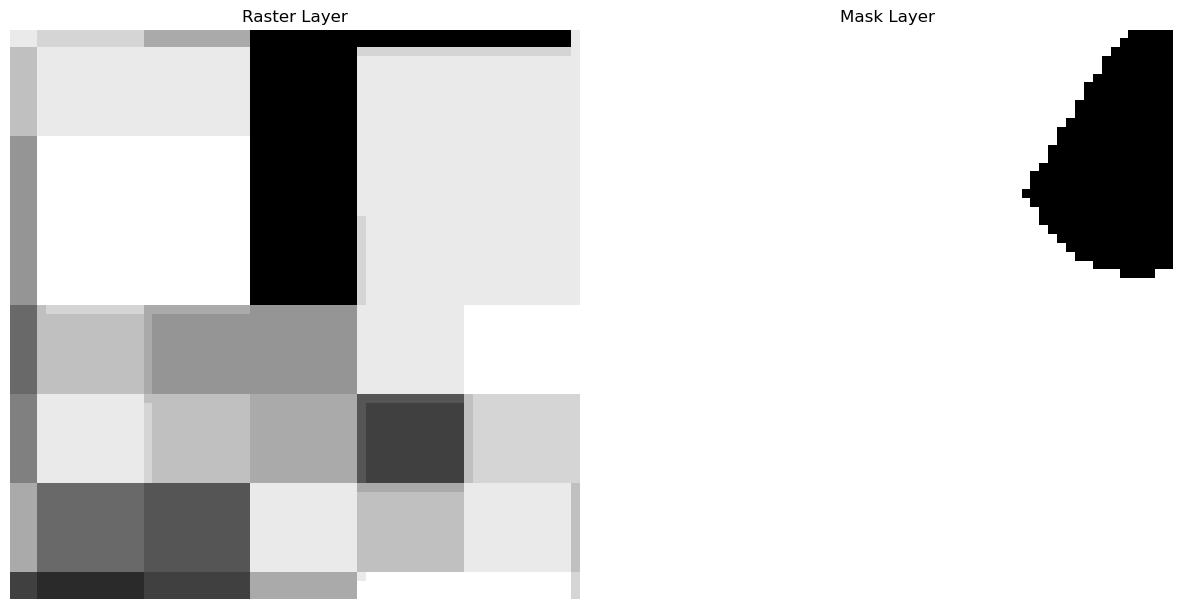

Number of bands in raster: 6


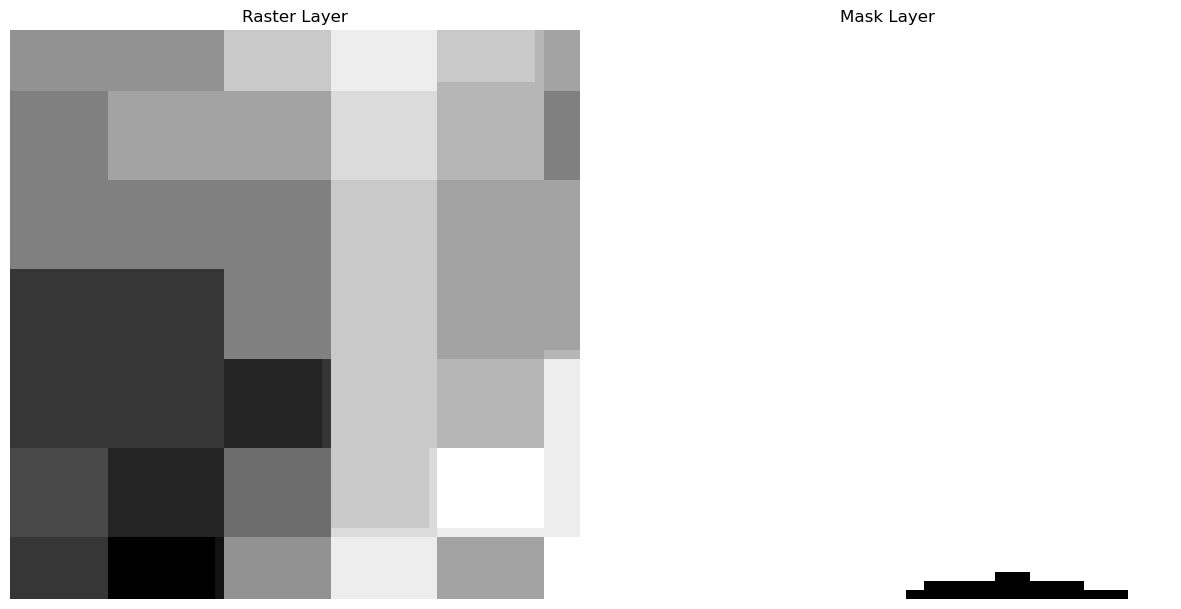

Number of bands in raster: 6


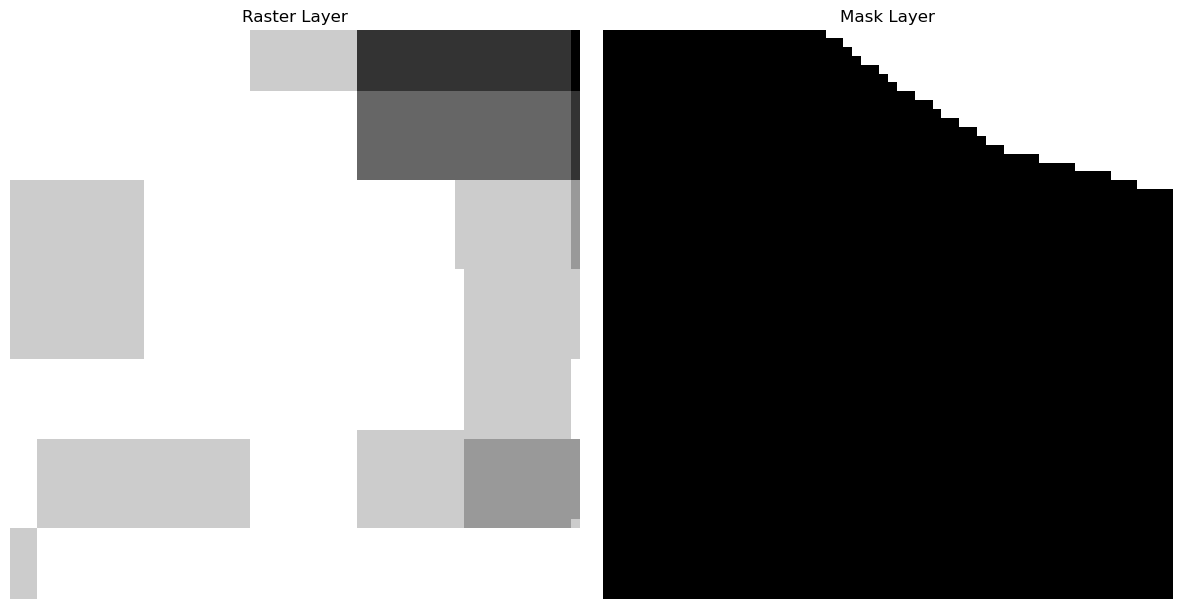

Number of bands in raster: 6


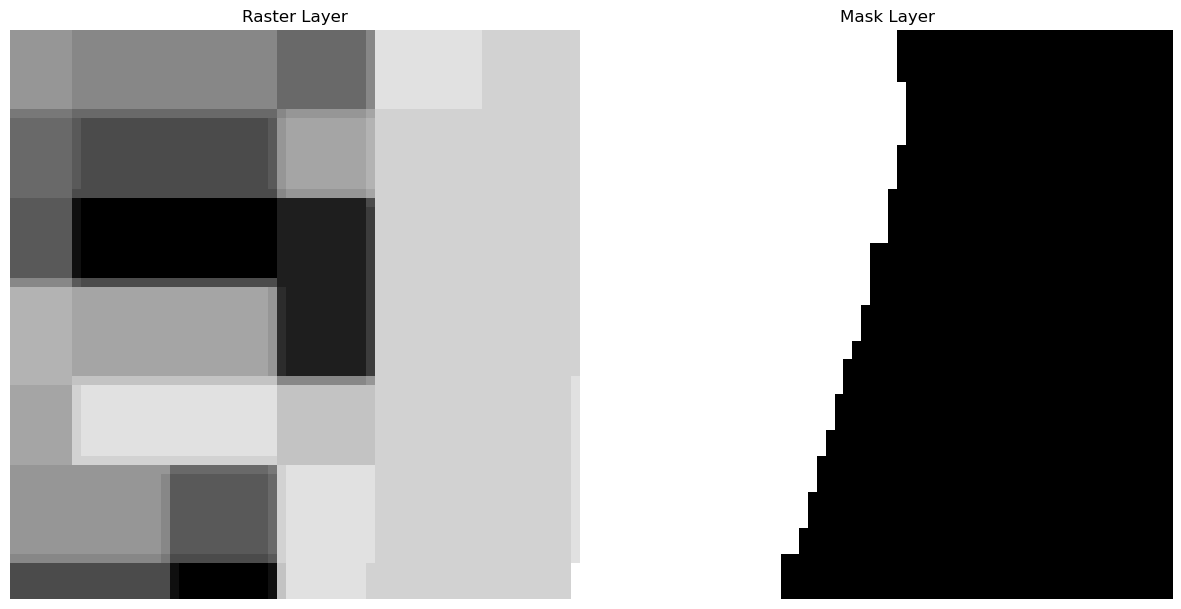

In [34]:
import os
import random
import rasterio
import matplotlib.pyplot as plt

# Output directories
output_raster_dir = "sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/rasterlayer"
output_mask_dir = "sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/masklayer"
patch_size = 64

# Get a list of patch files
raster_files = sorted([f for f in os.listdir(output_raster_dir) if f.endswith('.tif')])
mask_files = sorted([f for f in os.listdir(output_mask_dir) if f.endswith('.tif')])

# Randomly select 4 unique indices
if len(raster_files) >= 4 and len(mask_files) >= 4:
    random_indices = random.sample(range(len(raster_files)), 4)
else:
    print("Not enough raster or mask files available.")
    random_indices = []

# Visualization function for raster and mask
def visualize_layers(raster_file, mask_file):
    with rasterio.open(raster_file) as src_raster:
        # Check the number of bands in the raster
        num_bands = src_raster.count
        print(f"Number of bands in raster: {num_bands}")  # Debugging line

        # Select the first band (ensure it's the correct band)
        raster_data = src_raster.read(1)  # Change this if you want a different band

    with rasterio.open(mask_file) as src_mask:
        mask_data = src_mask.read(1)  # Read the first band (or layer)

    # Create a figure with subplots
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Plot raster
    ax[0].imshow(raster_data, cmap='gray')
    ax[0].set_title('Raster Layer')
    ax[0].axis('off')  # Hide axis

    # Plot mask
    ax[1].imshow(mask_data, cmap='gray')
    ax[1].set_title('Mask Layer')
    ax[1].axis('off')  # Hide axis

    plt.tight_layout()
    plt.show()

# Visualize the selected random patches
for index in random_indices:
    visualize_layers(os.path.join(output_raster_dir, raster_files[index]),
                     os.path.join(output_mask_dir, mask_files[index]))

In [35]:
import os
import rasterio
import numpy as np

output_raster_dir = "sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/rasterlayer"
output_mask_dir = "sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/masklayer"

# Function to check if a file is a valid raster
def is_valid_raster(file_path):
    try:
        with rasterio.open(file_path) as src:
            return True
    except:
        return False

# Function to load patches and calculate metrics
def load_and_calculate_metrics(raster_dir, mask_dir):
    raster_files = sorted([f for f in os.listdir(raster_dir) if is_valid_raster(os.path.join(raster_dir, f))])
    mask_files = sorted([f for f in os.listdir(mask_dir) if is_valid_raster(os.path.join(mask_dir, f))])

    if not raster_files or not mask_files:
        print("No valid raster or mask files found.")
        return

    # Load first raster file to extract dimensions
    with rasterio.open(os.path.join(raster_dir, raster_files[0])) as src:
        raster_height = src.height
        raster_width = src.width
        raster_channels = src.count

    # Count the number of patches
    raster_length = len(raster_files)
    mask_length = len(mask_files)

    # Check for the total classes in the mask
    mask_classes = set()

    for mask_file in mask_files:
        with rasterio.open(os.path.join(mask_dir, mask_file)) as mask_src:
            mask_data = mask_src.read(1)  # Read the first band
            mask_classes.update(np.unique(mask_data))

    # Print the calculated metrics
    print("Length of raster dataset:", raster_length)
    print("Length of mask dataset:", mask_length)
    print("Raster height:", raster_height)
    print("Raster width:", raster_width)
    print("Raster channels:", raster_channels)
    print("Total classes of mask (1 for glacier, 0 for non-glacier):", sorted(mask_classes))

# Call the function to load datasets and calculate metrics
load_and_calculate_metrics(output_raster_dir, output_mask_dir)

Length of raster dataset: 42708
Length of mask dataset: 42708
Raster height: 64
Raster width: 64
Raster channels: 6
Total classes of mask (1 for glacier, 0 for non-glacier): [0, 1]


In [36]:
import os
import numpy as np
import rasterio

# Define paths
output_raster_dir = "sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/rasterlayer"
output_mask_dir = "sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/masklayer"

# Function to load raster dataset with shape check and remove mismatched files
def load_and_clean_raster_dataset(raster_dir, mask_dir):
    raster_files = sorted([f for f in os.listdir(raster_dir) if f.endswith('.tif')])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.tif')])

    image_list, mask_list = [], []

    ref_shape = None
    for r_file, m_file in zip(raster_files, mask_files):
        r_path = os.path.join(raster_dir, r_file)
        m_path = os.path.join(mask_dir, m_file)

        with rasterio.open(r_path) as r_src, rasterio.open(m_path) as m_src:
            r_data = r_src.read()
            m_data = m_src.read(1)

            # Initialize reference shape
            if ref_shape is None:
                ref_shape = (r_data.shape, m_data.shape)

            # Check shape match
            if r_data.shape == ref_shape[0] and m_data.shape == ref_shape[1]:
                image_list.append(r_data)
                mask_list.append(m_data)
            else:
                # Removing mismatched files
                print(f"Skipping and removing mismatched: {r_file} | {r_data.shape} vs {m_data.shape}")
                os.remove(r_path)
                os.remove(m_path)

    return (
        np.stack(image_list, axis=0) if image_list else np.array([]),
        np.array(mask_list) if mask_list else np.array([])
    )

# Load consistent raster and mask data and clean mismatched files
image_dataset, mask_dataset = load_and_clean_raster_dataset(output_raster_dir, output_mask_dir)
print("Loaded image dataset shape:", image_dataset.shape)
print("Loaded mask dataset shape:", mask_dataset.shape)

# Transpose image data to (n_samples, height, width, channels)
if image_dataset.ndim == 4:
    image_dataset = np.transpose(image_dataset, (0, 2, 3, 1))  # NCHW → NHWC
    print("Transposed image dataset shape:", image_dataset.shape)
else:
    print("Warning: Unexpected image dataset shape.")

# Extract image properties
if image_dataset.size > 0:
    image_height, image_width, image_channels = image_dataset.shape[1:]
    print(f"Image HxW: {image_height}x{image_width}, Channels: {image_channels}")
else:
    print("Empty image dataset!")

# Unique classes in mask
unique_labels = np.unique(mask_dataset)
total_classes = len(unique_labels)
print("Unique labels in masks:", unique_labels)

# One-hot encode the mask
from keras.utils import to_categorical
labels_categorical_dataset = to_categorical(mask_dataset, num_classes=total_classes)

# Train-test split
from sklearn.model_selection import train_test_split
if image_dataset.shape[0] == labels_categorical_dataset.shape[0]:
    X_train, X_test, y_train, y_test = train_test_split(
        image_dataset, labels_categorical_dataset, test_size=0.2, random_state=100
    )
    print("Train-test split done.")
    print("Train shapes:", X_train.shape, y_train.shape)
    print("Test shapes:", X_test.shape, y_test.shape)
else:
    print("Mismatch in number of images and masks!")

Loaded image dataset shape: (42708, 6, 64, 64)
Loaded mask dataset shape: (42708, 64, 64)
Transposed image dataset shape: (42708, 64, 64, 6)
Image HxW: 64x64, Channels: 6
Unique labels in masks: [0. 1.]
Train-test split done.
Train shapes: (34166, 64, 64, 6) (34166, 64, 64, 2)
Test shapes: (8542, 64, 64, 6) (8542, 64, 64, 2)


In [37]:
output_raster_dir = "sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/rasterlayer"
output_mask_dir = "sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/masklayer"
patch_size = 64  # Ensure your patches match your input shape

# Function to load raster dataset
def load_raster_dataset(directory):
    image_list = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.tif'):
            file_path = os.path.join(directory, filename)
            with rasterio.open(file_path) as src:
                image_data = src.read()
                image_list.append(image_data)
    return np.stack(image_list, axis=0) if image_list else np.array([])

In [38]:
# Function to load mask dataset
def load_mask_dataset(directory):
    mask_list = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.tif'):
            file_path = os.path.join(directory, filename)
            with rasterio.open(file_path) as src:
                mask_data = src.read(1)
                mask_list.append(mask_data)
    return np.stack(mask_list, axis=0) if mask_list else np.array([])

# Load datasets
image_dataset = load_raster_dataset(output_raster_dir)
mask_dataset = load_mask_dataset(output_mask_dir)

# Transpose image dataset to have channels last
image_dataset = np.transpose(image_dataset, (0, 2, 3, 1))

# Normalize image data
#image_dataset = image_dataset.astype('float32') / 255.0

# Convert mask to categorical
unique_labels = np.unique(mask_dataset)
total_classes = len(unique_labels)
mask_dataset_cat = to_categorical(mask_dataset, num_classes=total_classes)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    image_dataset, mask_dataset_cat, test_size=0.2, random_state=100
)

In [39]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, 
    UpSampling2D, Concatenate, Add, Dense, MultiHeadAttention, LayerNormalization
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision
import segmentation_models as sm 

In [40]:
# === 2. Jaccard Coefficient Metric ===
def jaccard_coef(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    y_true_flatten = tf.reshape(y_true, [-1])
    y_pred_flatten = tf.reshape(y_pred, [-1])
    
    intersection = tf.reduce_sum(y_true_flatten * y_pred_flatten)
    final_coef_value = (intersection + 1.0) / (tf.reduce_sum(y_true_flatten) + tf.reduce_sum(y_pred_flatten) - intersection + 1.0)
    
    return final_coef_value

In [41]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# === Building Blocks ===
def res_block(x, filters, kernel_size=3):
    shortcut = Conv2D(filters, 1, padding='same')(x)
    shortcut = BatchNormalization()(shortcut)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def vision_transformer_block(x, patch_size, embed_dim, num_heads, num_blocks):
    input_shape = x.shape[1:3]  # (height, width)
    patch_h, patch_w = patch_size, patch_size

    num_patches_h = input_shape[0] // patch_h
    num_patches_w = input_shape[1] // patch_w
    num_patches = num_patches_h * num_patches_w
    patch_dim = x.shape[-1] * patch_h * patch_w

    batch_size = tf.shape(x)[0]
    
    patches = tf.image.extract_patches(
        images=x,
        sizes=[1, patch_h, patch_w, 1],
        strides=[1, patch_h, patch_w, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )

    patches = tf.reshape(patches, [batch_size, num_patches, patch_dim])

    embedded = Dense(embed_dim)(patches)

    position_embedding = Embedding(input_dim=num_patches, output_dim=embed_dim)
    positions = tf.range(start=0, limit=num_patches, delta=1)
    embedded += position_embedding(positions)

    for _ in range(num_blocks):
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(embedded, embedded)
        attn_output = Dropout(0.1)(attn_output)
        embedded = LayerNormalization(epsilon=1e-6)(embedded + attn_output)

        ffn_output = Dense(embed_dim * 4, activation='relu')(embedded)
        ffn_output = Dense(embed_dim)(ffn_output)
        ffn_output = Dropout(0.1)(ffn_output)
        embedded = LayerNormalization(epsilon=1e-6)(embedded + ffn_output)

    # Reshape back to feature map
    grid_size_h = num_patches_h
    grid_size_w = num_patches_w
    x = tf.reshape(embedded, [batch_size, grid_size_h, grid_size_w, embed_dim])

    # Resize to original input shape
    x = tf.image.resize(x, [input_shape[0], input_shape[1]])
    return x

def attention_gate(x, skip, filters):
    g1 = Conv2D(filters, 1, padding='same')(x)
    g1 = BatchNormalization()(g1)

    x1 = Conv2D(filters, 1, padding='same')(skip)
    x1 = BatchNormalization()(x1)

    attention = Activation('relu')(g1 + x1)
    attention = Conv2D(1, 1, activation='sigmoid')(attention)

    skip = tf.multiply(skip, attention)
    return skip

# === GlaViTU Model ===
def build_glavitu(input_shape=(64, 64, 6), n_classes=2):
    inputs = Input(shape=input_shape)

    # Initial Convolution
    x = Conv2D(64, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Vision Transformer Block
    vt = vision_transformer_block(x, patch_size=4, embed_dim=64, num_heads=4, num_blocks=4)

    # Fusion
    fused = Concatenate()([x, vt])
    fused = Conv2D(128, 1, padding='same')(fused)
    fused = BatchNormalization()(fused)
    fused = Activation('relu')(fused)

    # Encoder
    e1 = res_block(fused, 128)
    p1 = MaxPooling2D(pool_size=(2, 2))(e1)

    e2 = res_block(p1, 256)
    p2 = MaxPooling2D(pool_size=(2, 2))(e2)

    e3 = res_block(p2, 512)

    # Decoder
    u1 = UpSampling2D(size=(2, 2))(e3)
    a1 = attention_gate(u1, e2, 256)
    u1 = Concatenate()([u1, a1])
    u1 = res_block(u1, 256)

    u2 = UpSampling2D(size=(2, 2))(u1)
    a2 = attention_gate(u2, e1, 128)
    u2 = Concatenate()([u2, a2])
    u2 = res_block(u2, 128)

    # Output
    outputs = Conv2D(n_classes, 1, activation='softmax')(u2)

    model = Model(inputs, outputs)
    return model

In [42]:
# === 6. Compile the Model ===
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
total_classes = y_train.shape[-1]  # Assuming y_train is one-hot encoded

model = build_glavitu(input_shape=input_shape, n_classes=total_classes)

dice_loss = sm.losses.DiceLoss(class_weights=[0.3, 0.7])
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

model = build_glavitu(input_shape=(64, 64, 6), n_classes=2)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 64, 64, 6)]          0         []                            
                                                                                                  
 conv2d_72 (Conv2D)          (None, 64, 64, 64)           3520      ['input_4[0][0]']             
                                                                                                  
 batch_normalization_63 (Ba  (None, 64, 64, 64)           256       ['conv2d_72[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_42 (Activation)  (None, 64, 64, 64)           0         ['batch_normalization_63

In [43]:
# === 7. Callbacks ===
model_save_path = 'sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/sf/model/top6_glavitu_all_area.h5'

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

model_checkpoint = ModelCheckpoint(
    model_save_path,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

In [44]:
# === 8. Training ===
batch_size = 16

history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=1000,
    validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/1000
2136/2136 [==============================] - ETA: 0s - loss: 0.3451 - accuracy: 0.8511
Epoch 1: val_loss improved from inf to 0.29828, saving model to sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/sf/model/top6_glavitu_all_area.h5


/home/sarvesh/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2136/2136 [==============================] - 273s 116ms/step - loss: 0.3451 - accuracy: 0.8511 - val_loss: 0.2983 - val_accuracy: 0.8690
Epoch 2/1000
2136/2136 [==============================] - ETA: 0s - loss: 0.2917 - accuracy: 0.8758
Epoch 2: val_loss improved from 0.29828 to 0.26772, saving model to sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/sf/model/top6_glavitu_all_area.h5
2136/2136 [==============================] - 262s 122ms/step - loss: 0.2917 - accuracy: 0.8758 - val_loss: 0.2677 - val_accuracy: 0.8858
Epoch 3/1000
2136/2136 [==============================] - ETA: 0s - loss: 0.2754 - accuracy: 0.8828
Epoch 3: val_loss improved from 0.26772 to 0.26619, saving model to sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/sf/model/top6_glavitu_all_area.h5
2136/2136 [==============================] - 269s 126ms/step - loss: 0.2754 - accuracy: 0.8828 - val_loss: 0.2662 - val_accuracy: 0.8893
Epoch 4/1000
2136/2136 [==============================] - ETA: 0s - loss: 0.2650 - accura

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2136/2136 [==============================] - ETA: 0s - loss: 0.0696 - accuracy: 0.9711
Epoch 61: val_loss did not improve from 0.09879
2136/2136 [==============================] - 274s 128ms/step - loss: 0.0696 - accuracy: 0.9711 - val_loss: 0.1047 - val_accuracy: 0.9580
Epoch 62/1000
2084/2136 [============================>.] - ETA: 6s - loss: 0.0692 - accuracy: 0.9714

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2136/2136 [==============================] - ETA: 0s - loss: 0.0437 - accuracy: 0.9818
Epoch 94: val_loss did not improve from 0.08666
2136/2136 [==============================] - 273s 128ms/step - loss: 0.0437 - accuracy: 0.9818 - val_loss: 0.0916 - val_accuracy: 0.9656
Epoch 95/1000
 801/2136 [==========>...................] - ETA: 2:35 - loss: 0.0415 - accuracy: 0.9827

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2136/2136 [==============================] - ETA: 0s - loss: 0.0423 - accuracy: 0.9824
Epoch 97: val_loss did not improve from 0.08666
2136/2136 [==============================] - 275s 129ms/step - loss: 0.0423 - accuracy: 0.9824 - val_loss: 0.0908 - val_accuracy: 0.9657
Epoch 98/1000
1113/2136 [==============>...............] - ETA: 2:01 - loss: 0.0419 - accuracy: 0.9826

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [45]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Model output shape:", model.output.shape)

X_train shape: (34166, 64, 64, 6)
y_train shape: (34166, 64, 64, 2)
Model output shape: (None, 64, 64, 2)


In [46]:
# Check model output shape at different stages
print("Model output shape:", model.output.shape)

# Check the shape of y_train
print("Training labels shape:", y_train.shape)

Model output shape: (None, 64, 64, 2)
Training labels shape: (34166, 64, 64, 2)


Text(0.5, 1.0, 'Model Accuracy')

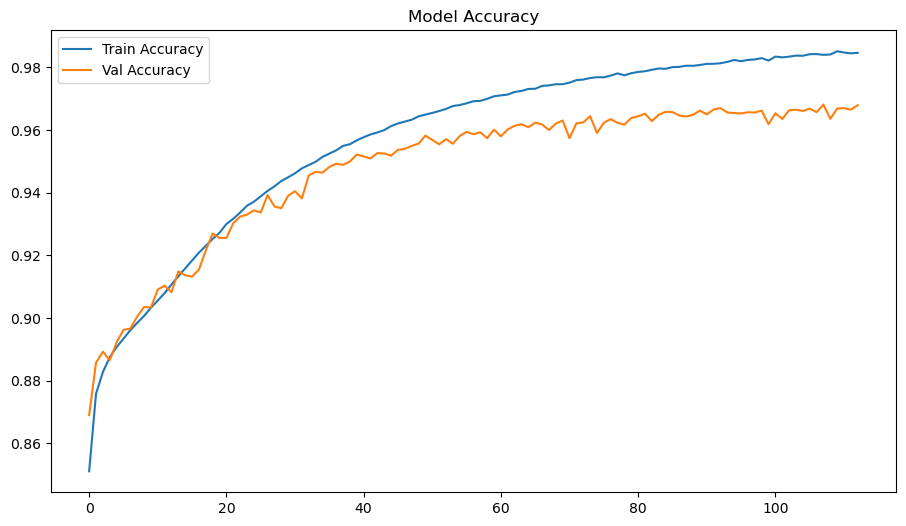

In [47]:
# Plot training results
plt.figure(figsize=(24, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Model Accuracy')

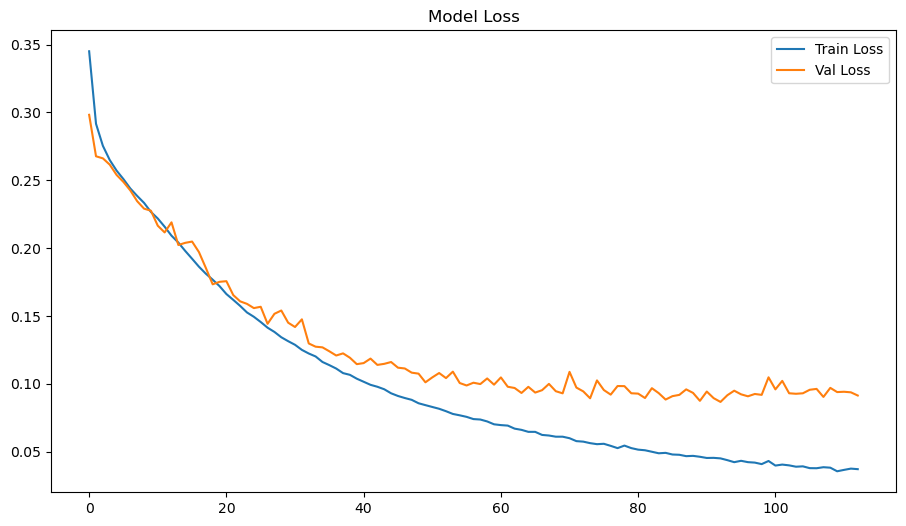

In [48]:
plt.figure(figsize=(24, 6))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [49]:
#Predict on the test set
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)

267/267 [==============================] - 20s 72ms/step


In [50]:
# Convert y_test to argmax for comparison
y_test_argmax = np.argmax(y_test, axis=3)

In [51]:
# Select a random test image for prediction visualization
test_image_number = random.randint(0, len(X_test) - 1)

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

1/1 [==============================] - 0s 44ms/step


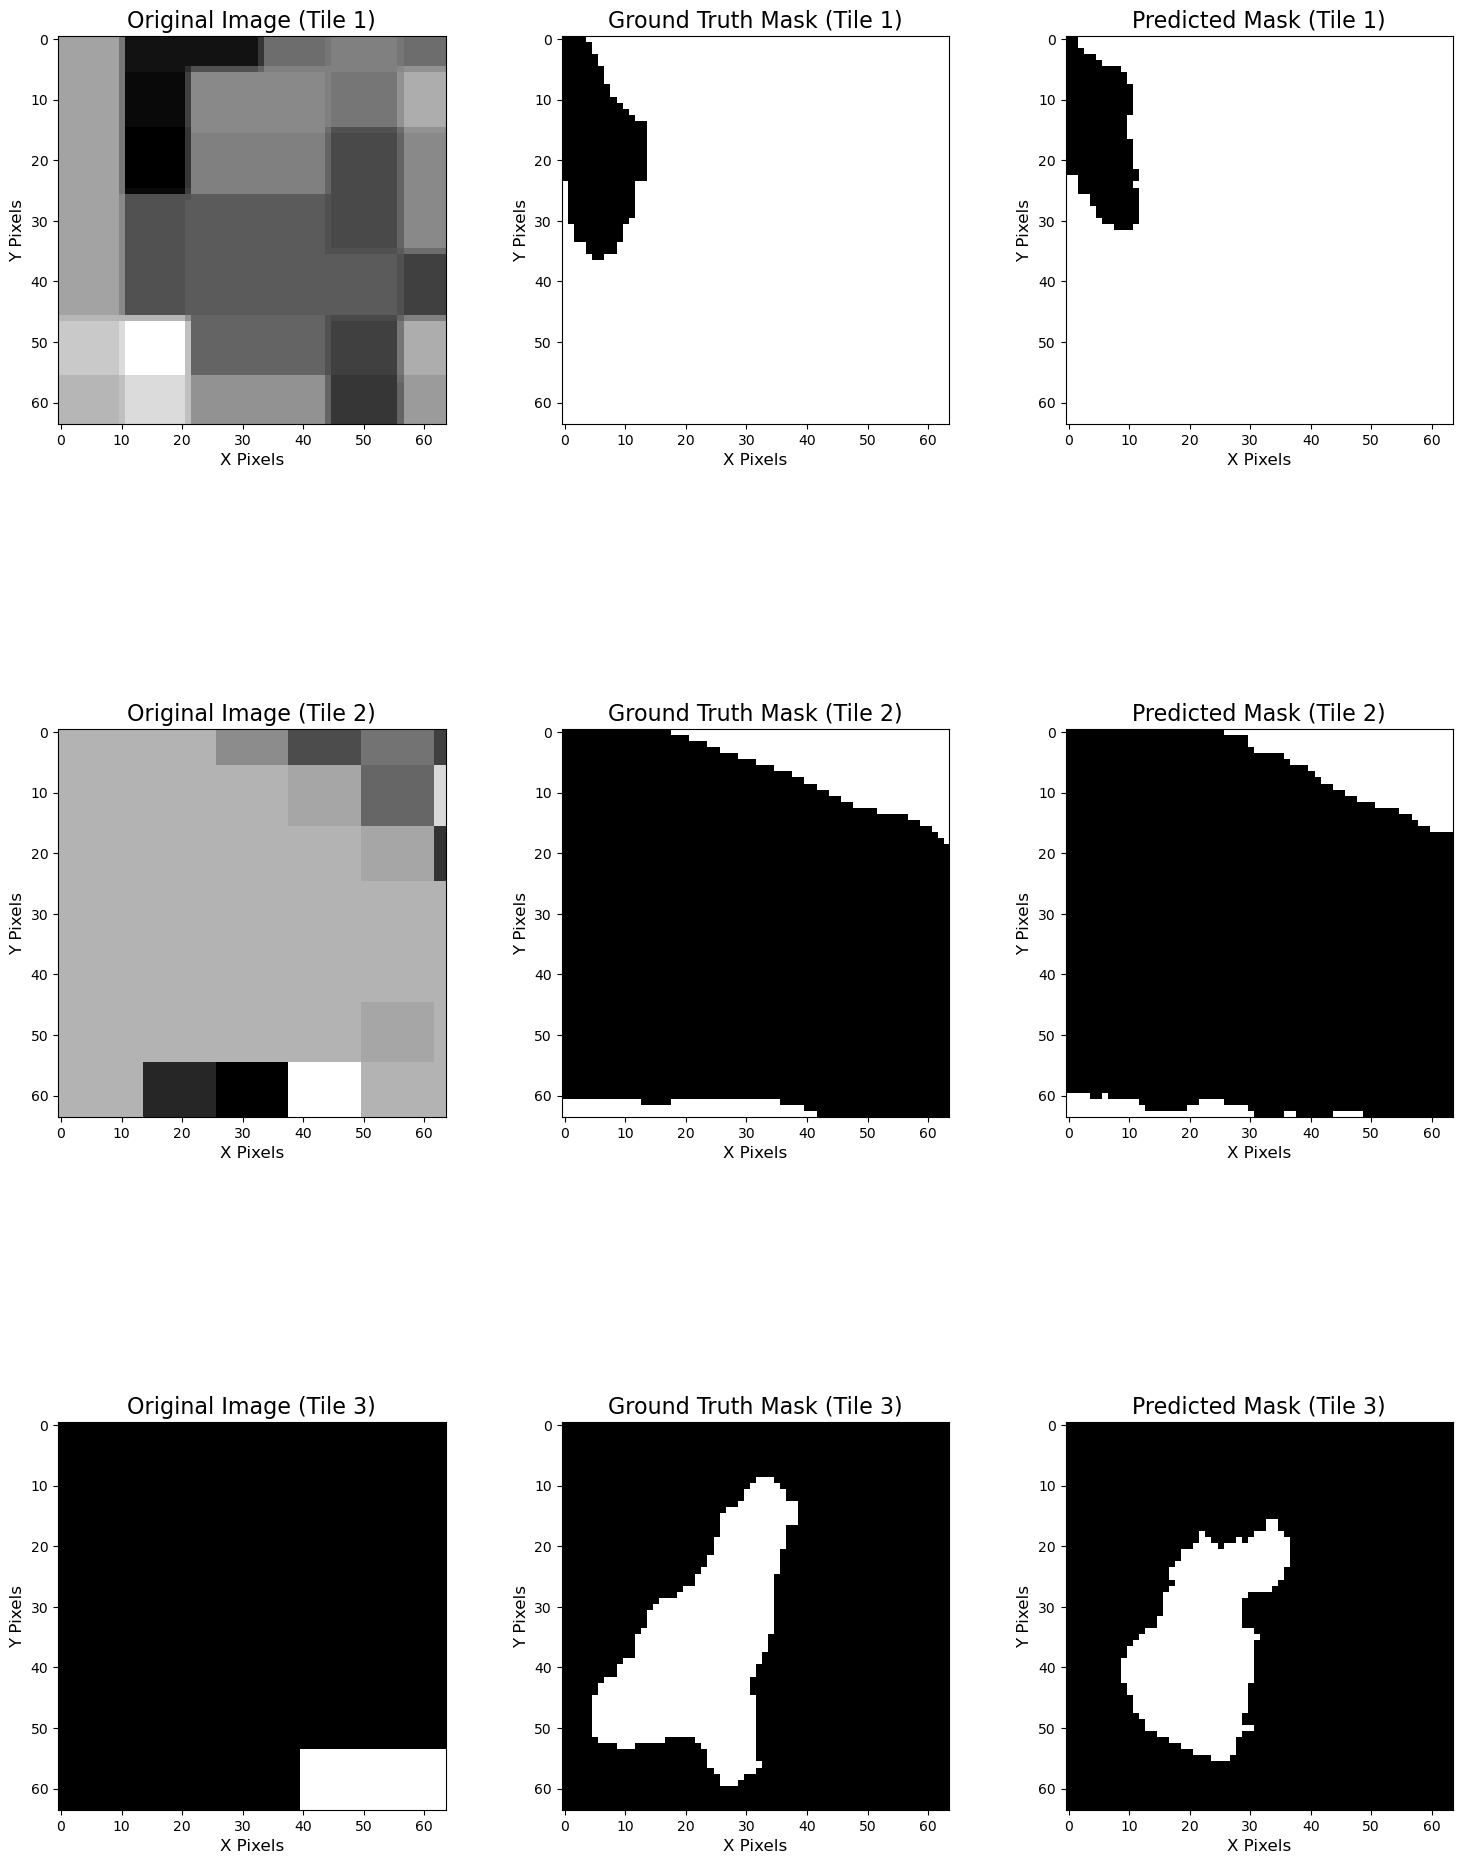

In [52]:
# Define the figure size and the spacing between subplots
plt.figure(figsize=(18, 24))  # Adjusted size for three rows
plt.subplots_adjust(wspace=0.3, hspace=0.5)  # Increased spacing between plots and rows

# Loop through the first three tiles in the test set
for i in range(3):
    test_image = X_test[i]
    ground_truth_image = np.argmax(y_test[i], axis=-1)  # Decategorize the mask
    predicted_mask = model.predict(np.expand_dims(test_image, axis=0))
    predicted_image = np.argmax(predicted_mask[0], axis=-1)  # Decategorize predicted mask

    # Original Image
    plt.subplot(3, 3, i * 3 + 1)
    plt.title(f"Original Image (Tile {i+1})", fontsize=16)
    plt.imshow(test_image[..., 0], cmap='gray')  # Show first channel only
    plt.xlabel("X Pixels", fontsize=12)
    plt.ylabel("Y Pixels", fontsize=12)

    # Ground Truth Mask
    plt.subplot(3, 3, i * 3 + 2)
    plt.title(f"Ground Truth Mask (Tile {i+1})", fontsize=16)
    plt.imshow(ground_truth_image, cmap='gray')
    plt.xlabel("X Pixels", fontsize=12)
    plt.ylabel("Y Pixels", fontsize=12)

    # Predicted Mask
    plt.subplot(3, 3, i * 3 + 3)
    plt.title(f"Predicted Mask (Tile {i+1})", fontsize=16)
    plt.imshow(predicted_image, cmap='gray')
    plt.xlabel("X Pixels", fontsize=12)
    plt.ylabel("Y Pixels", fontsize=12)

# Show the plot
plt.show()

In [53]:
from tensorflow.keras.models import load_model

# Load the model with custom objects
model_path = 'sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/sf/model/top6_glavitu_all_area.h5'
# Load the model (no custom objects used)
model = load_model(model_path, compile=False)

# Print model summary
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 64, 64, 6)]          0         []                            
                                                                                                  
 conv2d_72 (Conv2D)          (None, 64, 64, 64)           3520      ['input_4[0][0]']             
                                                                                                  
 batch_normalization_63 (Ba  (None, 64, 64, 64)           256       ['conv2d_72[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_42 (Activation)  (None, 64, 64, 64)           0         ['batch_normalization_63

In [54]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from rasterio.features import shapes
import fiona
from shapely.geometry import shape, mapping
import os

# Define paths
model_path = 'sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/sf/model/top6_glavitu_all_area.h5'
raster_files = [
    'sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/top6band/raster_satopanth_normalized_6band.tif',
    'sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/top6band/sikkim_chaudhary_255_final_6band.tif',
    'sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/top6band/KASHMIR_NORMALIZED_255_final_6band.tif',
    'sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/top6band/raster_cb__normalized_6band.tif',
    'sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/top6band/cb_vali_normalized_128_6band.tif'
]
output_dir = 'sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/top6_sf'

# Load the model
model = load_model(model_path, compile=False)

# Patch and overlap settings
patch_size = 64
overlap = 32
stride = patch_size - overlap

# Blending matrix
blend_matrix = np.ones((patch_size, patch_size))
for i in range(overlap):
    weight = (i + 1) / overlap
    blend_matrix[i, :] *= weight
    blend_matrix[-(i + 1), :] *= weight
    blend_matrix[:, i] *= weight
    blend_matrix[:, -(i + 1)] *= weight

# Process each raster file
for raster_file in raster_files:
    with rasterio.open(raster_file) as src:
        raster_data = src.read()
        raster_profile = src.profile
        transform = src.transform
        crs = src.crs

    # Transpose raster to (H, W, C)
    raster_data = np.transpose(raster_data, (1, 2, 0))
    height, width, channels = raster_data.shape

    # Pad raster
    pad_h = (stride - height % stride) % stride
    pad_w = (stride - width % stride) % stride
    raster_data_padded = np.pad(raster_data, ((0, pad_h), (0, pad_w), (0, 0)), mode='reflect')

    # Predict full raster via sliding window
    predicted_raster = np.zeros((raster_data_padded.shape[0], raster_data_padded.shape[1]), dtype=np.float32)
    weight_sum = np.zeros_like(predicted_raster)

    for i in range(0, raster_data_padded.shape[0] - patch_size + 1, stride):
        for j in range(0, raster_data_padded.shape[1] - patch_size + 1, stride):
            patch = raster_data_padded[i:i + patch_size, j:j + patch_size, :]
            patch = np.expand_dims(patch, axis=0)
            prediction = model.predict(patch, verbose=0)
            predicted_patch = np.argmax(prediction, axis=-1).squeeze()

            predicted_raster[i:i + patch_size, j:j + patch_size] += predicted_patch * blend_matrix
            weight_sum[i:i + patch_size, j:j + patch_size] += blend_matrix

    # Normalize and crop
    weight_sum[weight_sum == 0] = 1
    predicted_raster = (predicted_raster / weight_sum).astype(np.uint8)
    predicted_raster = predicted_raster[:height, :width]

    # Save predicted raster
    os.makedirs(output_dir, exist_ok=True)
    base_name = os.path.splitext(os.path.basename(raster_file))[0]
    predicted_raster_path = os.path.join(output_dir, f'{base_name}_cb_segnet.tif')

    raster_profile.update({
        'count': 1,
        'dtype': 'uint8',
        'compress': 'lzw',
        'nodata': 0
    })

    with rasterio.open(predicted_raster_path, 'w', **raster_profile) as dst:
        dst.write(predicted_raster, 1)

    print(f"Predicted raster saved: {predicted_raster_path}")

    # Convert raster to shapefile
    shapefile_path = os.path.join(output_dir, f'{base_name}_segnet_mask.shp')
    shapes_gen = shapes(predicted_raster, mask=predicted_raster > 0, transform=transform)

    schema = {
        'geometry': 'Polygon',
        'properties': {'value': 'int'}
    }

    with fiona.open(shapefile_path, 'w', driver='ESRI Shapefile', crs=crs, schema=schema) as shp:
        for geom, value in shapes_gen:
            shp.write({
                'geometry': mapping(shape(geom)),
                'properties': {'value': int(value)}
            })

    print(f"Shapefile saved: {shapefile_path}")

Predicted raster saved: sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/top6_sf/raster_satopanth_normalized_6band_cb_segnet.tif
Shapefile saved: sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/top6_sf/raster_satopanth_normalized_6band_segnet_mask.shp
Predicted raster saved: sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/top6_sf/sikkim_chaudhary_255_final_6band_cb_segnet.tif
Shapefile saved: sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/top6_sf/sikkim_chaudhary_255_final_6band_segnet_mask.shp
Predicted raster saved: sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/top6_sf/KASHMIR_NORMALIZED_255_final_6band_cb_segnet.tif
Shapefile saved: sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/top6_sf/KASHMIR_NORMALIZED_255_final_6band_segnet_mask.shp
Predicted raster saved: sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/top6_sf/raster_cb__normalized_6band_cb_segnet.tif
Shapefile saved: sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/top6_sf/raster_cb__n


=== Processing KASHMIR ===
Confusion Matrix:
[[23108992   154585]
 [   83891   532492]]
Overall Accuracy: 0.9900
Mean IoU: 0.8402
F1 Score: 0.9060
Recall: 0.9286
Precision: 0.8857
Cohen's Kappa: 0.8119

=== Processing SIKKIM ===
Confusion Matrix:
[[18700650    79401]
 [  158011   345950]]
Overall Accuracy: 0.9877
Mean IoU: 0.7902
F1 Score: 0.8691
Recall: 0.8411
Precision: 0.9025
Cohen's Kappa: 0.7383

=== Processing UTTRAKHAND ===
Confusion Matrix:
[[6177544   44042]
 [ 434478 2381436]]
Overall Accuracy: 0.9471
Mean IoU: 0.8804
F1 Score: 0.9357
Recall: 0.9193
Precision: 0.9581
Cohen's Kappa: 0.8717

=== Processing CHANDRA BHAGA BASIN ===
Confusion Matrix:
[[94827537   528688]
 [ 1926188 10068417]]
Overall Accuracy: 0.9771
Mean IoU: 0.8894
F1 Score: 0.9393
Recall: 0.9169
Precision: 0.9651
Cohen's Kappa: 0.8786

=== Processing CB VALIDATION ===
Confusion Matrix:
[[20296735    98803]
 [ 1195445  1340681]]
Overall Accuracy: 0.9436
Mean IoU: 0.7244
F1 Score: 0.8218
Recall: 0.7619
Precision

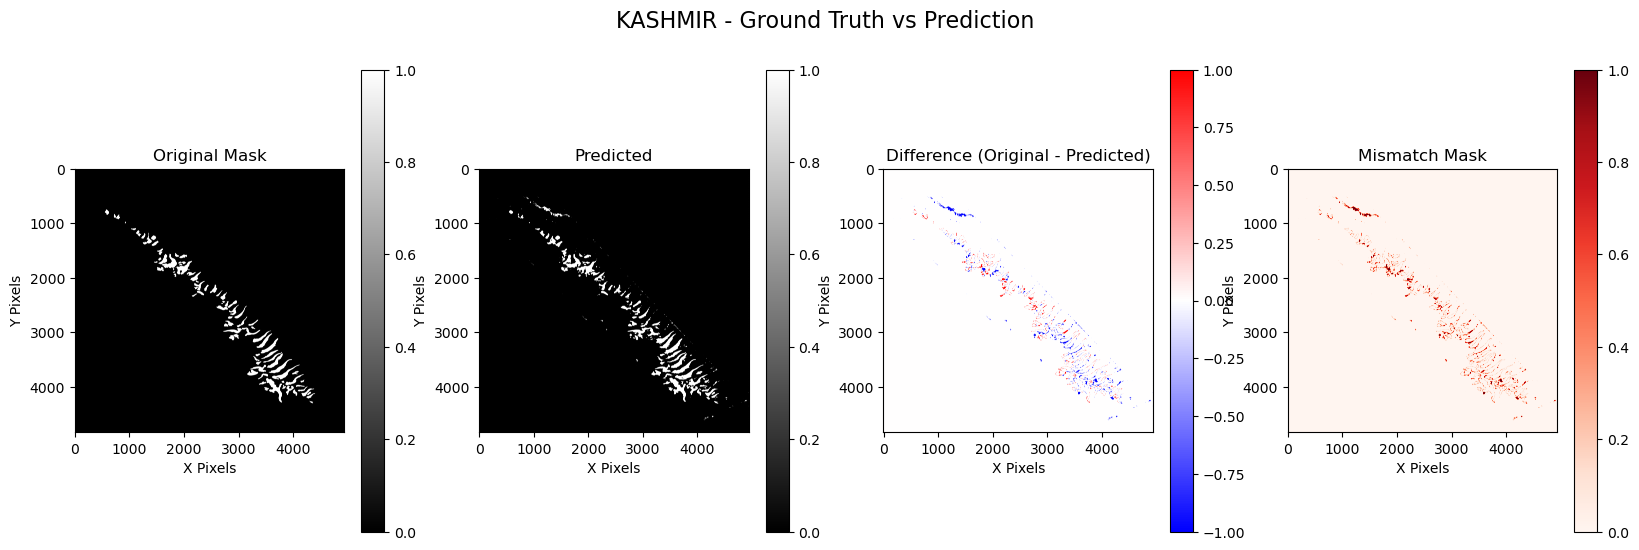

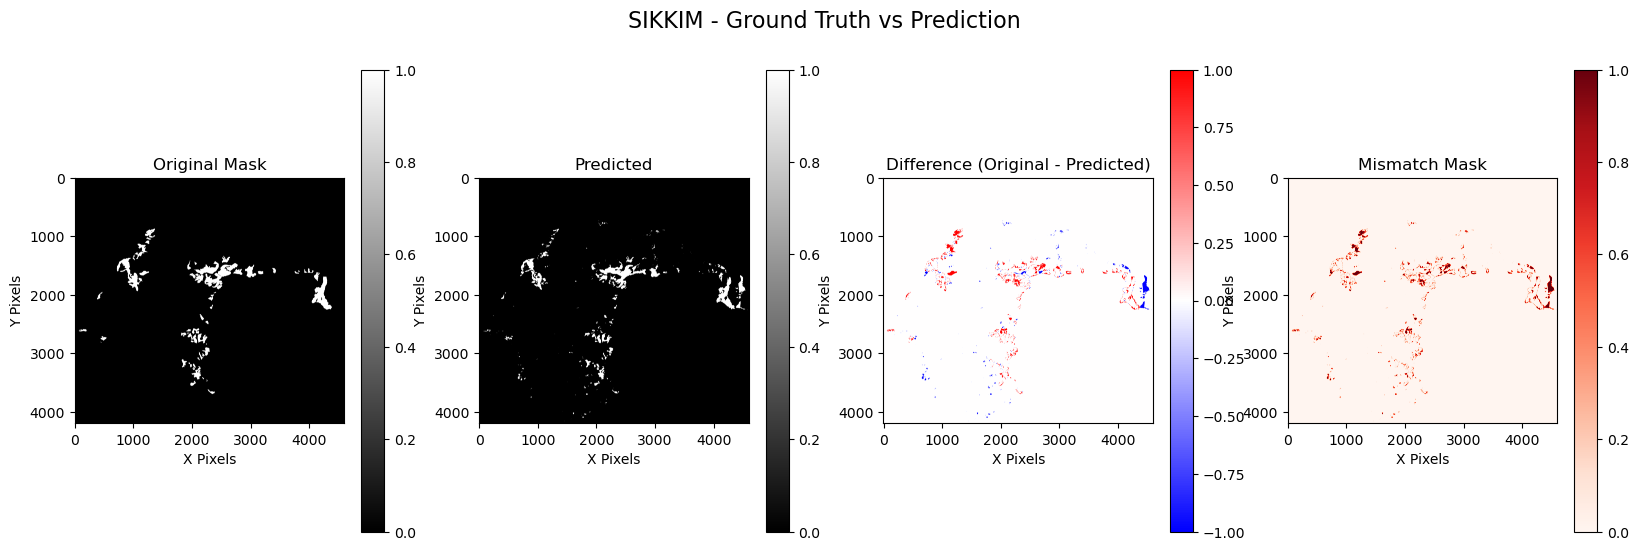

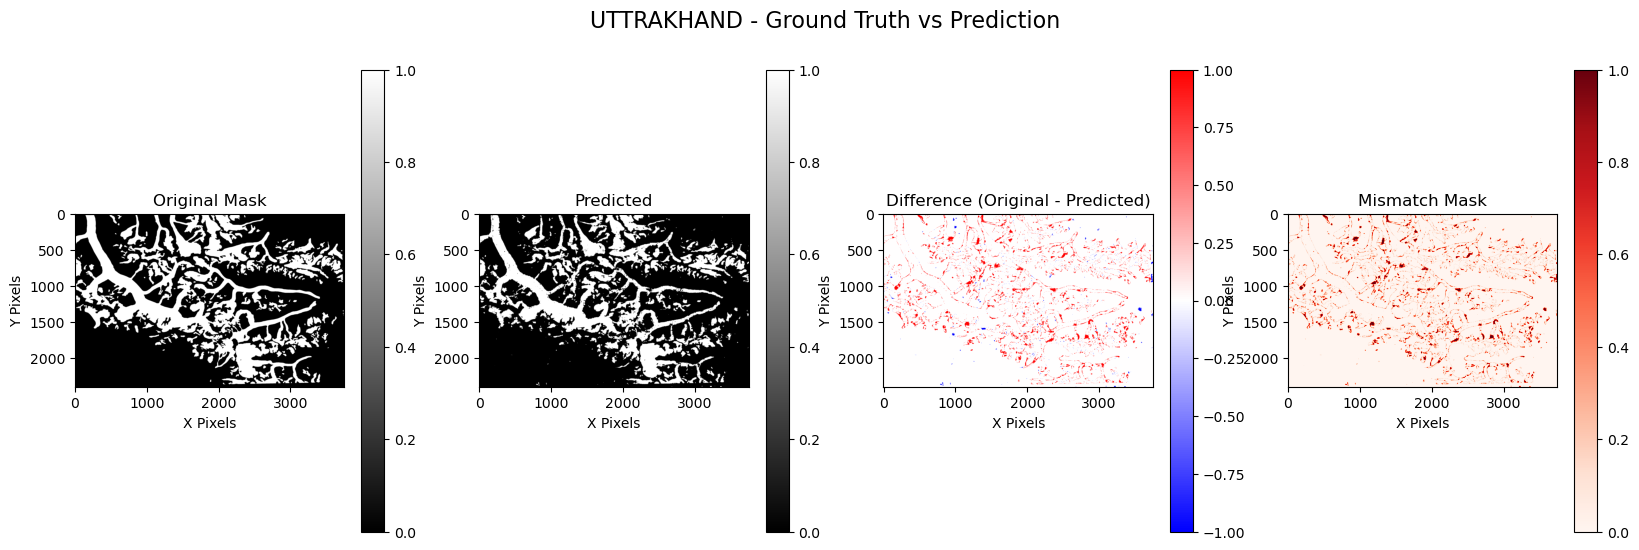

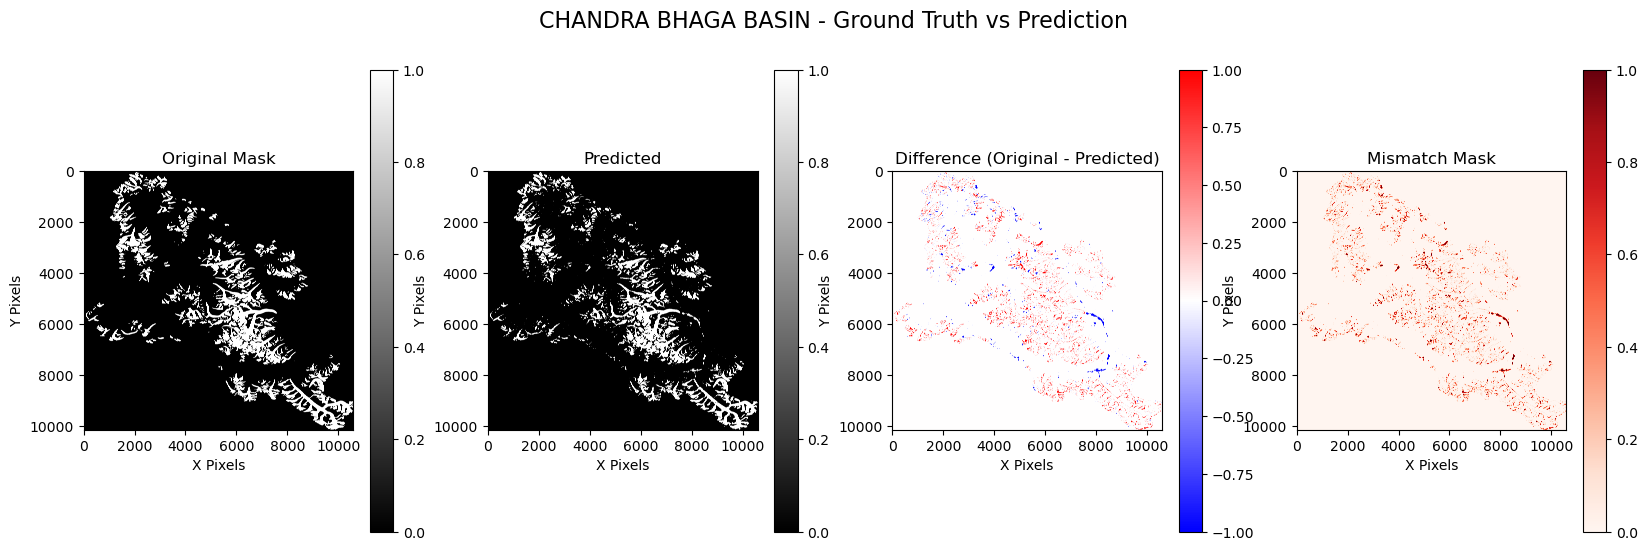

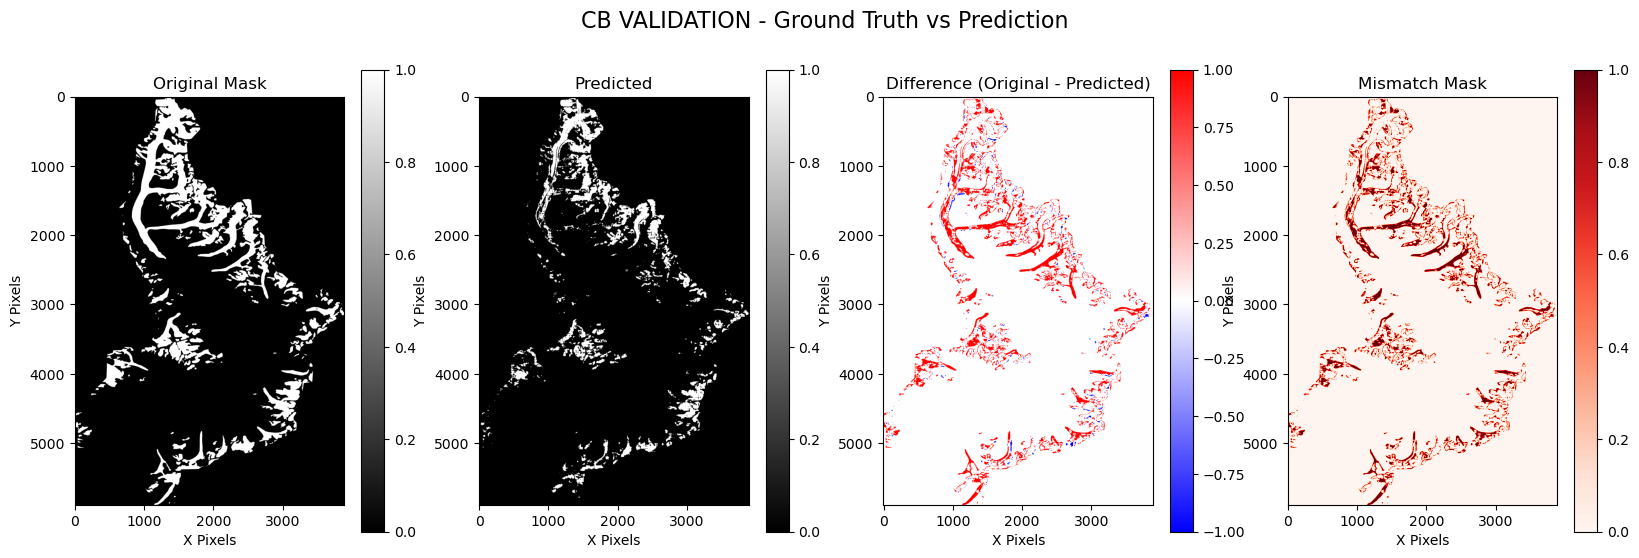

In [3]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, accuracy_score, jaccard_score, 
    f1_score, recall_score, precision_score, cohen_kappa_score
)
from rasterio.warp import reproject, Resampling
import os

# List of mask and predicted raster paths
data_pairs = [
    {
        'mask': 'sarvesh/new_layers_/mask_reprojected/KASHMIR_NORMALIZED_255_finalkasmircomplete_mask_reprojected.tif',
        'predicted': 'sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/top6_sf/KASHMIR_NORMALIZED_255_final_6band_cb_segnet.tif',
        'label': 'KASHMIR'
    },
    {
        'mask': 'sarvesh/DATASETS_NORMALIZED/sikkim_mask.tif',
        'predicted': 'sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/top6_sf/sikkim_chaudhary_255_final_6band_cb_segnet.tif',
        'label': 'SIKKIM'
    },
    {
        'mask': 'sarvesh/chandrabasin/dataset/new/masklayersato.tif',
        'predicted': 'sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/top6_sf/raster_satopanth_normalized_6band_cb_segnet.tif',
        'label': 'UTTRAKHAND'
    },
    {
        'mask': 'sarvesh/new_layers_/mask_reprojected/raster_cb__normalized_new_mask_reprojected.tif',
        'predicted': 'sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/top6_sf/raster_cb__normalized_6band_cb_segnet.tif',
        'label': 'CHANDRA BHAGA BASIN'
    },
    {
        'mask': 'sarvesh/DATASETS_NORMALIZED/CB_VALIDATION_MASK.tif',
        'predicted': 'sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/top6_sf/cb_vali_normalized_128_6band_cb_segnet.tif',
        'label': 'CB VALIDATION'
    },
]

# Loop over each pair
for pair in data_pairs:
    print(f"\n=== Processing {pair['label']} ===")

    # Load original mask
    with rasterio.open(pair['mask']) as src:
        original_mask = src.read(1)
        original_profile = src.profile

    # Load predicted raster
    with rasterio.open(pair['predicted']) as src:
        predicted_raster = src.read(1)

    # Resample predicted raster to match original mask dimensions
    resampled_predicted = np.empty_like(original_mask)
    with rasterio.open(pair['predicted']) as src_pred:
        reproject(
            source=rasterio.band(src_pred, 1),
            destination=resampled_predicted,
            src_transform=src_pred.transform,
            src_crs=src_pred.crs,
            dst_transform=original_profile['transform'],
            dst_crs=original_profile['crs'],
            resampling=Resampling.nearest
        )

    # Handle no-data masking
    nodata_val = original_profile.get('nodata')
    if nodata_val is not None:
        valid_mask = original_mask != nodata_val
    else:
        valid_mask = np.ones_like(original_mask, dtype=bool)

    # Filter only valid pixels
    original_mask_valid = original_mask[valid_mask]
    resampled_predicted_valid = resampled_predicted[valid_mask]

    # Compute metrics
    conf_matrix = confusion_matrix(original_mask_valid, resampled_predicted_valid)
    accuracy = accuracy_score(original_mask_valid, resampled_predicted_valid)
    iou = jaccard_score(original_mask_valid, resampled_predicted_valid, average='macro')
    f1 = f1_score(original_mask_valid, resampled_predicted_valid, average='macro')
    recall = recall_score(original_mask_valid, resampled_predicted_valid, average='macro')
    precision = precision_score(original_mask_valid, resampled_predicted_valid, average='macro')
    kappa = cohen_kappa_score(original_mask_valid, resampled_predicted_valid)

    # Print metrics
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Mean IoU: {iou:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")

    # Visualize - create new figure for each dataset
    fig, axes = plt.subplots(1, 4, figsize=(20, 6))
    fig.suptitle(f"{pair['label']} - Ground Truth vs Prediction", fontsize=16)

    # Original Mask
    im0 = axes[0].imshow(original_mask, cmap='gray')
    axes[0].set_title("Original Mask")
    plt.colorbar(im0, ax=axes[0])
    
    # Predicted
    im1 = axes[1].imshow(resampled_predicted, cmap='gray')
    axes[1].set_title("Predicted")
    plt.colorbar(im1, ax=axes[1])
    
    # Difference
    diff = original_mask.astype(int) - resampled_predicted.astype(int)
    im2 = axes[2].imshow(diff, cmap='bwr', vmin=-1, vmax=1)
    axes[2].set_title("Difference (Original - Predicted)")
    plt.colorbar(im2, ax=axes[2])
    
    # Difference Mask
    diff_mask = (original_mask != resampled_predicted).astype(int)
    im3 = axes[3].imshow(diff_mask, cmap='Reds')
    axes[3].set_title("Mismatch Mask")
    plt.colorbar(im3, ax=axes[3])

    for ax in axes:
        ax.set_xlabel("X Pixels")
        ax.set_ylabel("Y Pixels")

# Show all plots at once
plt.show()


=== Processing KASHMIR ===
Confusion Matrix:
[[23263577        0]
 [   83891   532492]]
Overall Accuracy: 0.9965
Mean IoU: 0.9302
F1 Score: 0.9626
Recall: 0.9319
Precision: 0.9982
Cohen's Kappa: 0.9252

=== Processing SIKKIM ===
Confusion Matrix:
[[18780051        0]
 [  158011   345950]]
Overall Accuracy: 0.9918
Mean IoU: 0.8391
F1 Score: 0.9049
Recall: 0.8432
Precision: 0.9958
Cohen's Kappa: 0.8100

=== Processing UTTRAKHAND ===
Confusion Matrix:
[[6221586       0]
 [ 434478 2381436]]
Overall Accuracy: 0.9519
Mean IoU: 0.8902
F1 Score: 0.9413
Recall: 0.9229
Precision: 0.9674
Cohen's Kappa: 0.8830

=== Processing CHANDRA BHAGA BASIN ===
Confusion Matrix:
[[95356225        0]
 [ 1926188 10068417]]
Overall Accuracy: 0.9821
Mean IoU: 0.9098
F1 Score: 0.9513
Recall: 0.9197
Precision: 0.9901
Cohen's Kappa: 0.9028

=== Processing CB VALIDATION ===
Confusion Matrix:
[[20395538        0]
 [ 1195445  1340681]]
Overall Accuracy: 0.9479
Mean IoU: 0.7366
F1 Score: 0.8316
Recall: 0.7643
Precision

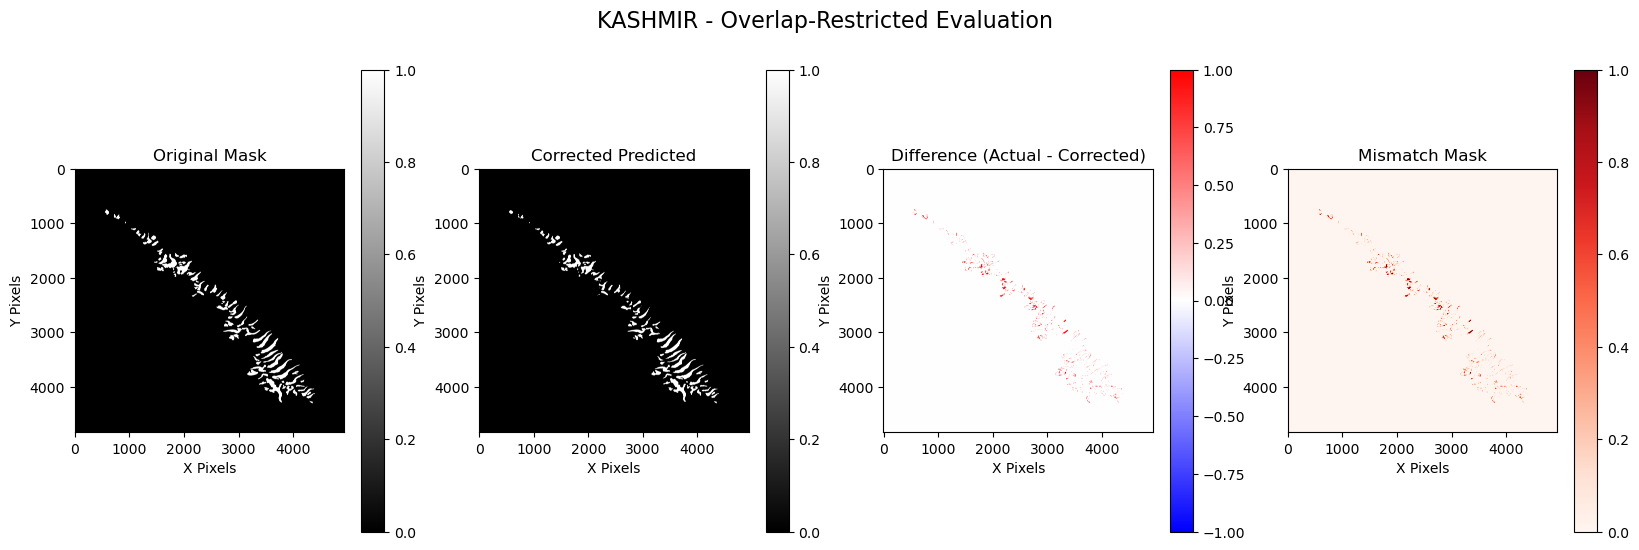

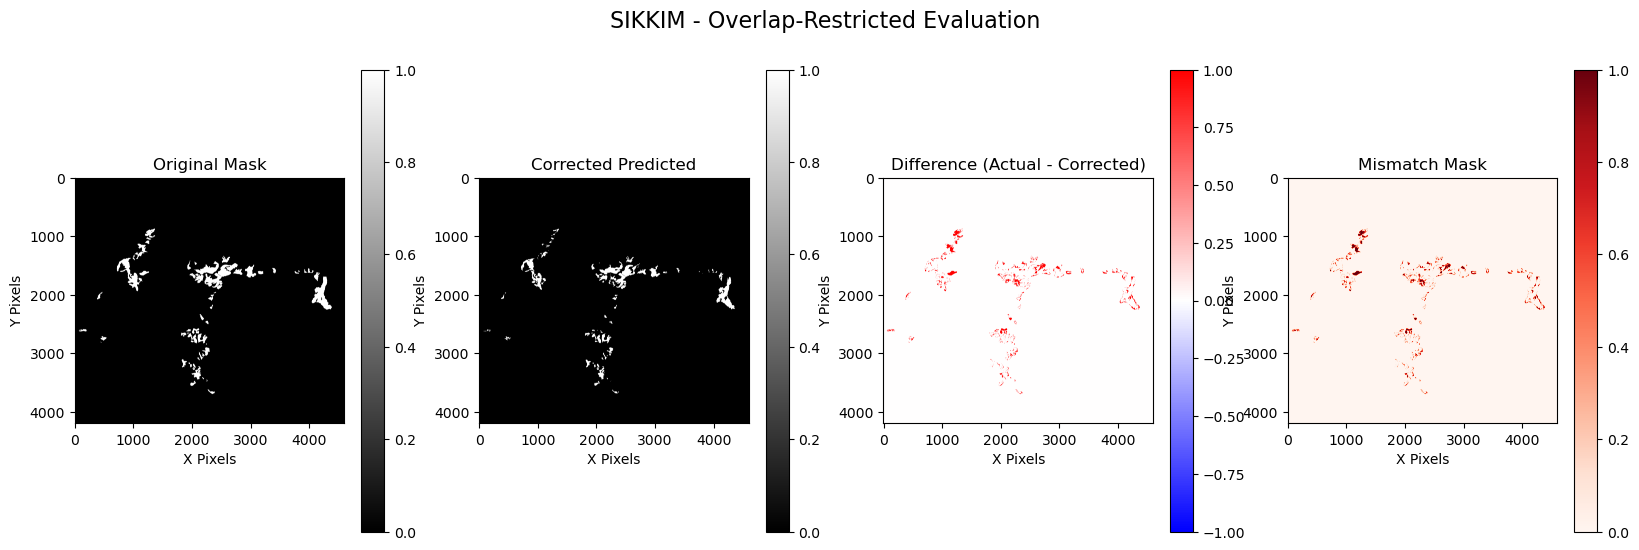

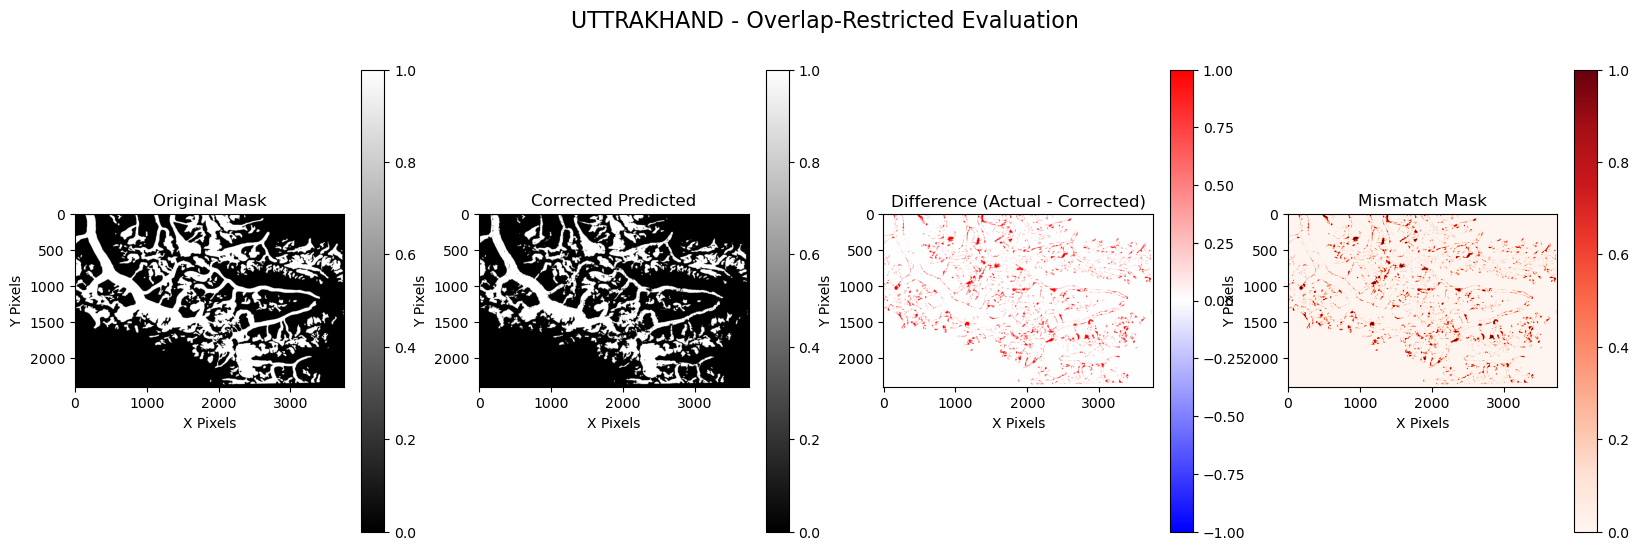

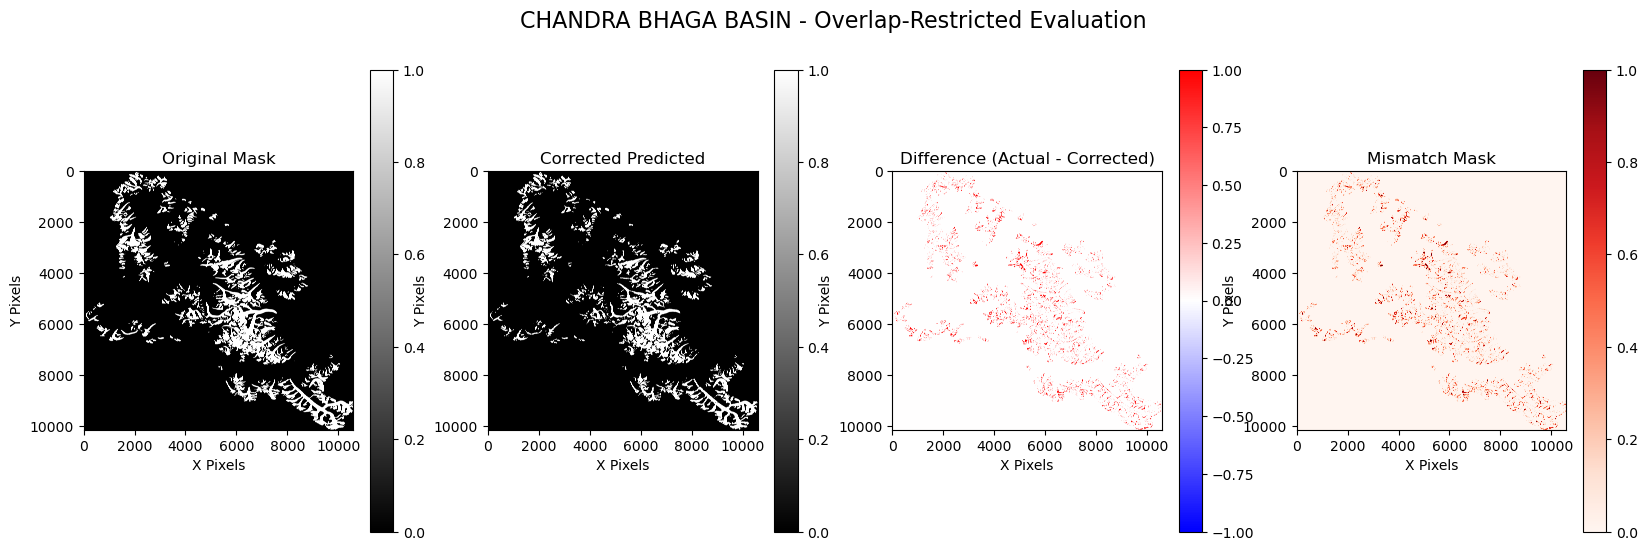

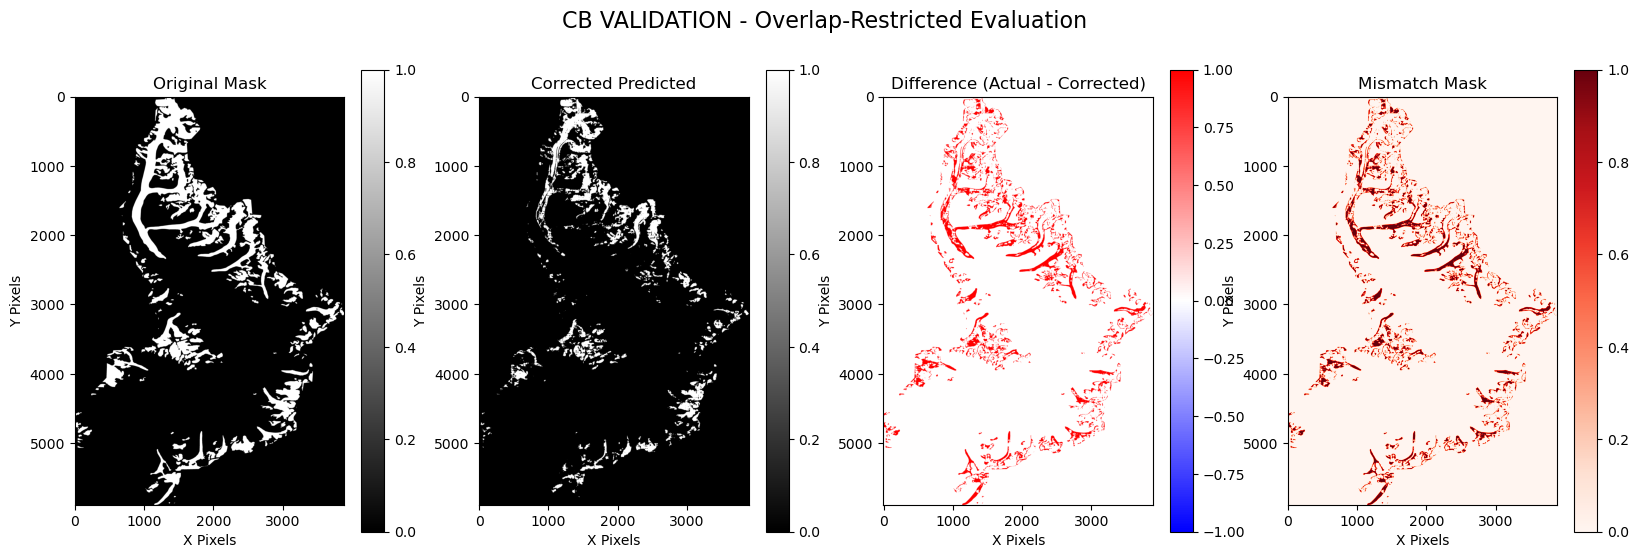

In [4]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, accuracy_score, jaccard_score, 
    f1_score, recall_score, precision_score, cohen_kappa_score
)
from rasterio.warp import reproject, Resampling

# List of mask and predicted raster paths
data_pairs = [
    {
        'mask': 'sarvesh/new_layers_/mask_reprojected/KASHMIR_NORMALIZED_255_finalkasmircomplete_mask_reprojected.tif',
        'predicted': 'sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/top6_sf/KASHMIR_NORMALIZED_255_final_6band_cb_segnet.tif',
        'label': 'KASHMIR'
    },
    {
        'mask': 'sarvesh/DATASETS_NORMALIZED/sikkim_mask.tif',
        'predicted': 'sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/top6_sf/sikkim_chaudhary_255_final_6band_cb_segnet.tif',
        'label': 'SIKKIM'
    },
    {
        'mask': 'sarvesh/chandrabasin/dataset/new/masklayersato.tif',
        'predicted': 'sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/top6_sf/raster_satopanth_normalized_6band_cb_segnet.tif',
        'label': 'UTTRAKHAND'
    },
    {
        'mask': 'sarvesh/new_layers_/mask_reprojected/raster_cb__normalized_new_mask_reprojected.tif',
        'predicted': 'sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/top6_sf/raster_cb__normalized_6band_cb_segnet.tif',
        'label': 'CHANDRA BHAGA BASIN'
    },
    {
        'mask': 'sarvesh/DATASETS_NORMALIZED/CB_VALIDATION_MASK.tif',
        'predicted': 'sarvesh/DATASETS_NORMALIZED/all_sau_net/glavitu/top6/top6_sf/cb_vali_normalized_128_6band_cb_segnet.tif',
        'label': 'CB VALIDATION'
    },
]

for pair in data_pairs:
    print(f"\n=== Processing {pair['label']} ===")

    # Load actual mask
    with rasterio.open(pair['mask']) as src:
        original_mask = src.read(1)
        original_profile = src.profile

    # Load predicted raster
    with rasterio.open(pair['predicted']) as src:
        predicted_raster = src.read(1)

    # Resample predicted to match ground truth mask
    resampled_predicted = np.empty_like(original_mask)
    with rasterio.open(pair['predicted']) as src_pred:
        reproject(
            source=rasterio.band(src_pred, 1),
            destination=resampled_predicted,
            src_transform=src_pred.transform,
            src_crs=src_pred.crs,
            dst_transform=original_profile['transform'],
            dst_crs=original_profile['crs'],
            resampling=Resampling.nearest
        )

    # Handle no-data masking
    nodata_val = original_profile.get('nodata')
    if nodata_val is not None:
        valid_mask = original_mask != nodata_val
    else:
        valid_mask = np.ones_like(original_mask, dtype=bool)

    # === Key step: Remove predictions outside actual mask ===
    # Wherever actual mask is 0, predicted should be set to 0
    corrected_predicted = resampled_predicted.copy()
    corrected_predicted[original_mask == 0] = 0

    # Filter only valid pixels
    original_mask_valid = original_mask[valid_mask]
    corrected_predicted_valid = corrected_predicted[valid_mask]

    # === Accuracy metrics ===
    conf_matrix = confusion_matrix(original_mask_valid, corrected_predicted_valid)
    accuracy = accuracy_score(original_mask_valid, corrected_predicted_valid)
    iou = jaccard_score(original_mask_valid, corrected_predicted_valid, average='macro')
    f1 = f1_score(original_mask_valid, corrected_predicted_valid, average='macro')
    recall = recall_score(original_mask_valid, corrected_predicted_valid, average='macro')
    precision = precision_score(original_mask_valid, corrected_predicted_valid, average='macro')
    kappa = cohen_kappa_score(original_mask_valid, corrected_predicted_valid)

    # Print results
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Mean IoU: {iou:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")

    # === Visualization ===
    fig, axes = plt.subplots(1, 4, figsize=(20, 6))
    fig.suptitle(f"{pair['label']} - Overlap-Restricted Evaluation", fontsize=16)

    # Original Mask
    im0 = axes[0].imshow(original_mask, cmap='gray')
    axes[0].set_title("Original Mask")
    plt.colorbar(im0, ax=axes[0])

    # Corrected Prediction
    im1 = axes[1].imshow(corrected_predicted, cmap='gray')
    axes[1].set_title("Corrected Predicted")
    plt.colorbar(im1, ax=axes[1])

    # Difference
    diff = original_mask.astype(int) - corrected_predicted.astype(int)
    im2 = axes[2].imshow(diff, cmap='bwr', vmin=-1, vmax=1)
    axes[2].set_title("Difference (Actual - Corrected)")
    plt.colorbar(im2, ax=axes[2])

    # Mismatch
    mismatch = (original_mask != corrected_predicted).astype(int)
    im3 = axes[3].imshow(mismatch, cmap='Reds')
    axes[3].set_title("Mismatch Mask")
    plt.colorbar(im3, ax=axes[3])

    for ax in axes:
        ax.set_xlabel("X Pixels")
        ax.set_ylabel("Y Pixels")

plt.show()